# **Step 0) Repo & environment & step 1) Data ETL (events → weekly panel)**

**Step 0 — Open a new Colab and run this first cell (mount Drive)**

In [ ]:
# ▶️ Cell 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 1 — Create a clean project folder in Drive**

In [ ]:
# ▶️ Cell 1: Create folders for this project
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/scg_project')
RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

for p in [PROJECT_ROOT, RAW_DIR, PROCESSED_DIR]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, RAW_DIR, PROCESSED_DIR


(PosixPath('/content/drive/MyDrive/scg_project'),
 PosixPath('/content/drive/MyDrive/scg_project/data/raw'),
 PosixPath('/content/drive/MyDrive/scg_project/data/processed'))

**Step 2 — Upload your raw files (one time)**

In [ ]:
# ▶️ (Optional) Cell 2A: Upload files into RAW_DIR from your computer
# If you already put files in Drive via the web UI, you can SKIP this cell.
import shutil, os
from google.colab import files

print("Select your 10 raw CSVs to upload...")
uploaded = files.upload()  # choose the CSVs from your machine

for name, data in uploaded.items():
    dst = RAW_DIR / name
    with open(dst, 'wb') as f:
        f.write(data)
    print("Saved to:", dst)


Select your 10 raw CSVs to upload...


Saving DeliveryToDistributor_unit.csv to DeliveryToDistributor_unit (1).csv
Saving DeliveryToDistributor_weight.csv to DeliveryToDistributor_weight (1).csv
Saving FactoryIssue_unit.csv to FactoryIssue_unit (1).csv
Saving FactoryIssue_weight.csv to FactoryIssue_weight (1).csv
Saving Nodes_and_Edges_Plant_and_Storage.csv to Nodes_and_Edges_Plant_and_Storage (1).csv
Saving Nodes_and_Edges_ProductGroup_and_Subgroup.csv to Nodes_and_Edges_ProductGroup_and_Subgroup (1).csv
Saving Production_unit.csv to Production_unit (1).csv
Saving Production_weight.csv to Production_weight (1).csv
Saving SalesOrder_unit.csv to SalesOrder_unit (1).csv
Saving SalesOrder_weight.csv to SalesOrder_weight (1).csv
Saved to: /content/drive/MyDrive/scg_project/data/raw/DeliveryToDistributor_unit (1).csv
Saved to: /content/drive/MyDrive/scg_project/data/raw/DeliveryToDistributor_weight (1).csv
Saved to: /content/drive/MyDrive/scg_project/data/raw/FactoryIssue_unit (1).csv
Saved to: /content/drive/MyDrive/scg_project

**Now verify the files are there:**

In [ ]:
# ▶️ Cell 2B: Verify the required filenames are present
import os

required = {
 'Production_unit.csv','Production_weight.csv',
 'FactoryIssue_unit.csv','FactoryIssue_weight.csv',
 'DeliveryToDistributor_unit.csv','DeliveryToDistributor_weight.csv',
 'SalesOrder_unit.csv','SalesOrder_weight.csv',
 'Nodes_and_Edges_Plant_and_Storage.csv',
 'Nodes_and_Edges_ProductGroup_and_Subgroup.csv'
}

present = set(os.listdir(RAW_DIR))
print("Missing files:", sorted(required - present))
print("Extra files  :", sorted(present - required))
print("All good?    :", (required - present) == set())


Missing files: []
Extra files  : ['DeliveryToDistributor_unit (1).csv', 'DeliveryToDistributor_unit (2).csv', 'DeliveryToDistributor_weight (1).csv', 'DeliveryToDistributor_weight (2).csv', 'FactoryIssue_unit (1).csv', 'FactoryIssue_unit (2).csv', 'FactoryIssue_weight (1).csv', 'FactoryIssue_weight (2).csv', 'Nodes_and_Edges_Plant_and_Storage (1).csv', 'Nodes_and_Edges_Plant_and_Storage (2).csv', 'Nodes_and_Edges_ProductGroup_and_Subgroup (1).csv', 'Nodes_and_Edges_ProductGroup_and_Subgroup (2).csv', 'Production_unit (1).csv', 'Production_unit (2).csv', 'Production_weight (1).csv', 'Production_weight (2).csv', 'SalesOrder_unit (1).csv', 'SalesOrder_unit (2).csv', 'SalesOrder_weight (1).csv', 'SalesOrder_weight (2).csv']
All good?    : True


**Step 3 — Run ETL (creates your 5 output files)**

In [ ]:
# ▶️ Cell 3: ETL = Raw CSVs → Clean outputs (CSV)
import pandas as pd, numpy as np
from pathlib import Path
import textwrap, datetime as dt

RAW_DIR = Path('/content/drive/MyDrive/scg_project/data/raw')
PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

def read_csv(path: Path):
    df = pd.read_csv(path)
    if "Date" in df.columns: df["Date"] = pd.to_datetime(df["Date"])
    return df

def normalize_sku(s: str) -> str:
    # One-off fix we saw in your data:
    return "POP001L12P" if s == "POP001L12P.1" else s

def melt_event_pair(units_path: Path, weight_path: Path, metric: str) -> pd.DataFrame:
    """
    Convert wide format (Date × SKU columns) to long format:
    (Date, SKU, metric, units, weight). 'metric' ∈ {prod, fi, dtd, so}
    """
    u = read_csv(units_path)
    w = read_csv(weight_path)
    sku_cols = [c for c in u.columns if c != "Date"]
    u_long = u.melt(id_vars=["Date"], value_vars=sku_cols, var_name="SKU", value_name="units")
    w_long = w.melt(id_vars=["Date"], value_vars=sku_cols, var_name="SKU", value_name="weight")
    ev = pd.merge(u_long, w_long, on=["Date","SKU"], how="outer")
    ev["metric"] = metric
    ev["SKU_norm"] = ev["SKU"].astype(str).map(normalize_sku)
    ev["units"]  = pd.to_numeric(ev["units"], errors="coerce").fillna(0.0)
    ev["weight"] = pd.to_numeric(ev["weight"], errors="coerce").fillna(0.0)
    return ev

def week_start(ts: pd.Series, week_starts_on="MON"):
    freq = "W-MON" if week_starts_on.upper()=="MON" else "W-SUN"
    return ts.dt.to_period(freq).dt.start_time

# ----- Load taxonomy (SKU → Subgroup/Group) -----
pg = read_csv(RAW_DIR / "Nodes_and_Edges_ProductGroup_and_Subgroup.csv")
pg.columns = [c.strip() for c in pg.columns]
pg["SKU"] = pg["Node"].astype(str)
pg["SKU_norm"] = pg["SKU"].map(normalize_sku)
sku_taxonomy = pg[["SKU_norm","Group","Sub-Group"]].rename(columns={"Sub-Group":"Subgroup"}).drop_duplicates()

# ----- Melt all event tables to one long DataFrame -----
pairs = [
    ("Production_unit.csv",            "Production_weight.csv",            "prod"),
    ("FactoryIssue_unit.csv",          "FactoryIssue_weight.csv",          "fi"),
    ("DeliveryToDistributor_unit.csv", "DeliveryToDistributor_weight.csv", "dtd"),
    ("SalesOrder_unit.csv",            "SalesOrder_weight.csv",            "so"),
]
events_long = pd.concat([
    melt_event_pair(RAW_DIR/u, RAW_DIR/w, m) for (u,w,m) in pairs
], ignore_index=True)

# Attach taxonomy and compute week start
events_long = events_long.merge(sku_taxonomy, on="SKU_norm", how="left")
events_long["week"] = week_start(events_long["Date"], "MON")

# Reorder and save
events_long = events_long[["Date","week","SKU","SKU_norm","Group","Subgroup","metric","units","weight"]]
events_long_path = PROCESSED_DIR / "events_long.csv"
events_long.to_csv(events_long_path, index=False)

# ----- Weekly subgroup panel -----
weekly = events_long.groupby(["week","Subgroup","metric"], as_index=False)[["units","weight"]].sum()
weekly_piv = weekly.pivot_table(index=["week","Subgroup"], columns="metric", values=["units","weight"], aggfunc="sum").fillna(0.0)

# Flatten MultiIndex columns: ('units','dtd') → 'dtd_u', etc.
colmap = {(measure,metric): f"{metric}_{'u' if measure=='units' else 'w'}"
          for (measure,metric) in weekly_piv.columns.to_flat_index()}
weekly_piv.columns = [colmap[c] for c in weekly_piv.columns.to_flat_index()]
weekly_piv = weekly_piv.reset_index()
for needed in ["prod_u","fi_u","dtd_u","so_u","prod_w","fi_w","dtd_w","so_w"]:
    if needed not in weekly_piv.columns: weekly_piv[needed] = 0.0

# Estimate subgroup mass-per-unit (tons per unit)
def safe_ratio(num, den): return float(num)/float(den) if den else np.nan
tot = weekly_piv.groupby("Subgroup")[["dtd_u","dtd_w","fi_u","fi_w","prod_u","prod_w"]].sum().reset_index()
mpu = []
for _, r in tot.iterrows():
    m = safe_ratio(r["dtd_w"], r["dtd_u"]) or safe_ratio(r["fi_w"], r["fi_u"]) or safe_ratio(r["prod_w"], r["prod_u"])
    mpu.append({"Subgroup": r["Subgroup"], "mpu_est_tons_per_unit": m})
weekly_piv = weekly_piv.merge(pd.DataFrame(mpu), on="Subgroup", how="left")
weekly_path = PROCESSED_DIR / "subgroup_weekly.csv"
weekly_piv.to_csv(weekly_path, index=False)

# ----- SKU dictionary (SKU → Subgroup/Group + per-SKU mpu) -----
sku_totals = events_long.groupby(["SKU_norm","metric"])[["units","weight"]].sum().reset_index()
sku_mpu = []
for sku, grp in sku_totals.groupby("SKU_norm"):
    def pick(metric):
        row = grp[grp["metric"]==metric]
        return safe_ratio(float(row["weight"].values[0]), float(row["units"].values[0])) if len(row) else np.nan
    m = pick("dtd") or pick("fi") or pick("prod")
    sku_mpu.append({"SKU_norm": sku, "sku_mpu_tons_per_unit": m})
sku_mpu = pd.DataFrame(sku_mpu)

sku_dict = pg[["SKU_norm","Sub-Group","Group"]].drop_duplicates() \
           .rename(columns={"Sub-Group":"Subgroup"}) \
           .merge(sku_mpu, on="SKU_norm", how="left")
sku_dict_path = PROCESSED_DIR / "sku_dictionary.csv"
sku_dict.to_csv(sku_dict_path, index=False)

# ----- Graph topology -----
ps = read_csv(RAW_DIR / "Nodes_and_Edges_Plant_and_Storage.csv")
ps.columns = [c.strip() for c in ps.columns]
ps["SKU"] = ps["Node"].astype(str); ps["SKU_norm"] = ps["SKU"].map(normalize_sku)
ps_edges = ps.merge(pg[["SKU","SKU_norm","Sub-Group","Group"]].rename(columns={"Sub-Group":"Subgroup"}),
                    on=["SKU","SKU_norm"], how="left").dropna(subset=["Subgroup"])
topology_path = PROCESSED_DIR / "graph_topology.csv"
ps_edges[["Plant","Storage Location","Subgroup","Group","SKU_norm"]].to_csv(topology_path, index=False)

# ----- ETL report -----
span = (events_long["Date"].min().date(), events_long["Date"].max().date())
report = f"""
ETL REPORT — {dt.datetime.now():%Y-%m-%d %H:%M:%S}
Range: {span[0]} → {span[1]}  |  #days: {events_long['Date'].nunique()}
#Subgroups: {weekly_piv['Subgroup'].nunique()}  |  #Weeks: {weekly_piv['week'].nunique()}
Files written to: {PROCESSED_DIR}
  - events_long.csv
  - subgroup_weekly.csv
  - sku_dictionary.csv
  - graph_topology.csv
"""
(PROCESSED_DIR / "etl_report.txt").write_text(textwrap.dedent(report))
print(report)



ETL REPORT — 2025-09-30 15:44:49
Range: 2023-01-01 → 2023-08-09  |  #days: 221
#Subgroups: 19  |  #Weeks: 33
Files written to: /content/drive/MyDrive/scg_project/data/processed
  - events_long.csv
  - subgroup_weekly.csv
  - sku_dictionary.csv
  - graph_topology.csv



**Step 4 — Quick sanity check (peek into the outputs)**

In [ ]:
# ▶️ Cell 4: Inspect the outputs
import pandas as pd
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

events_long = pd.read_csv(PROCESSED_DIR/'events_long.csv', parse_dates=['Date','week'])
weekly = pd.read_csv(PROCESSED_DIR/'subgroup_weekly.csv', parse_dates=['week'])
sku_dict = pd.read_csv(PROCESSED_DIR/'sku_dictionary.csv')
topology = pd.read_csv(PROCESSED_DIR/'graph_topology.csv')

print("events_long:", events_long.shape, "\n", events_long.head(), "\n")
print("subgroup_weekly:", weekly.shape, "\n", weekly.head(), "\n")
print("sku_dictionary:", sku_dict.shape, "\n", sku_dict.head(), "\n")
print("graph_topology:", topology.shape, "\n", topology.head(), "\n")


events_long: (36244, 9) 
         Date       week         SKU    SKU_norm Group Subgroup metric   units  \
0 2023-01-01 2022-12-27      AT5X5K      AT5X5K     A       AT   prod  1500.0   
1 2023-01-01 2022-12-27   ATN01K24P   ATN01K24P     A      ATN   prod  3500.0   
2 2023-01-01 2022-12-27   ATN02K12P   ATN02K12P     A      ATN   prod   200.0   
3 2023-01-01 2022-12-27   ATPA1K24P   ATPA1K24P     A     ATPA   prod     0.0   
4 2023-01-01 2022-12-27  ATPPCH5X5K  ATPPCH5X5K     A   ATPPCH   prod     0.0   

   weight  
0    37.5  
1    84.0  
2     4.8  
3     0.0  
4     0.0   

subgroup_weekly: (627, 11) 
         week Subgroup    dtd_u    fi_u  prod_u     so_u      dtd_w    fi_w  \
0 2022-12-27       AT  3024.00  2690.0  3000.0   3712.0   75.60000   67.25   
1 2022-12-27      ATN  6059.08  6545.0  8200.0  12629.0  145.41792  157.08   
2 2022-12-27     ATPA     0.00     0.0     0.0      0.0    0.00000    0.00   
3 2022-12-27   ATPPCH     0.00     0.0     0.0      0.0    0.00000    0.

# **Step 2: Feature & Graph Builder**

## **Step 2A — Imports & paths**

In [ ]:
# ▶️ Cell 5: Imports and paths (Colab-friendly)
import json, math
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/scg_project')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
RAW_DIR = PROJECT_ROOT / 'data' / 'raw'

# Quick check the ETL outputs exist
for fname in ["events_long.csv", "subgroup_weekly.csv", "sku_dictionary.csv", "graph_topology.csv"]:
    p = PROCESSED_DIR / fname
    assert p.exists(), f"Missing {p}. Re-run Step 1 (ETL) to create it."
print("Found ETL outputs. Proceeding with Step 2.")


Found ETL outputs. Proceeding with Step 2.


## **Step 2B — Load the ETL outputs**

In [ ]:
# ▶️ Cell 6: Load ETL outputs
events_long = pd.read_csv(PROCESSED_DIR/'events_long.csv', parse_dates=['Date','week'])
weekly = pd.read_csv(PROCESSED_DIR/'subgroup_weekly.csv', parse_dates=['week'])
sku_dict = pd.read_csv(PROCESSED_DIR/'sku_dictionary.csv')
topology = pd.read_csv(PROCESSED_DIR/'graph_topology.csv')

print("events_long:", events_long.shape)
print("subgroup_weekly:", weekly.shape)
print("topology:", topology.shape)
weekly.head()


events_long: (36244, 9)
subgroup_weekly: (627, 11)
topology: (6738, 5)


,week,Subgroup,dtd_u,fi_u,prod_u,so_u,dtd_w,fi_w,prod_w,so_w,mpu_est_tons_per_unit
0,2022-12-27,AT,3024.00,2690.0,3000.0,3712.0,75.60000,67.25,75.0,92.800,0.025
1,2022-12-27,ATN,6059.08,6545.0,8200.0,12629.0,145.41792,157.08,196.8,303.096,0.024
2,2022-12-27,ATPA,0.00,0.0,0.0,0.0,0.00000,0.00,0.0,0.000,NaN
3,2022-12-27,ATPPCH,0.00,0.0,0.0,0.0,0.00000,0.00,0.0,0.000,NaN
4,2022-12-27,ATWWP,0.00,0.0,0.0,194.0,0.00000,0.00,0.0,4.656,0.024


## **Step 2C — Build rolling 8-week features and targets**

In [ ]:
# ▶️ Cell 7: Rolling 8-week features (+ next-week targets)
W = 16  # longer history (16 weeks)


# Ensure weekly is sorted and complete per subgroup
weekly_sorted = weekly.sort_values(["Subgroup", "week"]).copy()

# Helper to add lagged columns
def add_lags(df, cols, lags):
    for c in cols:
        for L in lags:
            df[f"{c}_lag{L}"] = df.groupby("Subgroup")[c].shift(L)
    return df

metrics_u = ["prod_u","fi_u","dtd_u","so_u"]
metrics_w = ["prod_w","fi_w","dtd_w","so_w"]
all_metrics = metrics_u + metrics_w

# Add 1..W lags for each metric
weekly_feat = add_lags(weekly_sorted, all_metrics, list(range(1, W+1)))

# Rolling stats over the W-week window (using lag1..lagW)
def add_window_stats(df, base_cols, window=W):
    for base in base_cols:
        lag_cols = [f"{base}_lag{L}" for L in range(1, window+1)]
        df[f"{base}_mean{window}"] = df[lag_cols].mean(axis=1)
        df[f"{base}_std{window}"]  = df[lag_cols].std(axis=1)
        df[f"{base}_min{window}"]  = df[lag_cols].min(axis=1)
        df[f"{base}_max{window}"]  = df[lag_cols].max(axis=1)
    return df

weekly_feat = add_window_stats(weekly_feat, all_metrics, W)

# Calendar features (seasonality)
weekofyear = weekly_feat["week"].dt.isocalendar().week.astype(int)
weekly_feat["sin_weekofyear"] = np.sin(2 * np.pi * weekofyear / 52.0)
weekly_feat["cos_weekofyear"] = np.cos(2 * np.pi * weekofyear / 52.0)
weekly_feat["month"] = weekly_feat["week"].dt.month
weekly_feat["quarter"] = weekly_feat["week"].dt.quarter


# Carry forward subgroup MPU estimate as a static feature
# (optional, but handy to tie units and weight later)
# Already in weekly as 'mpu_est_tons_per_unit'
# Nothing to change; it stays as is.

# Targets: next-week actual dtd_u and dtd_w
weekly_feat["y_dtd_u"] = weekly_feat.groupby("Subgroup")["dtd_u"].shift(-1)
weekly_feat["y_dtd_w"] = weekly_feat.groupby("Subgroup")["dtd_w"].shift(-1)

# Drop rows that don't have a full past window or a next-week target
needed_cols = [f"{m}_lag{L}" for m in all_metrics for L in range(1, W+1)] + ["y_dtd_u","y_dtd_w"]
features = weekly_feat.dropna(subset=needed_cols).reset_index(drop=True)

print("Feature rows:", features.shape)
features.head()


Feature rows: (304, 177)


/tmp/ipython-input-1117094906.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1117094906.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1117094906.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-1117094906.py:12: PerformanceWarn

,week,Subgroup,dtd_u,fi_u,prod_u,so_u,dtd_w,fi_w,prod_w,so_w,...,so_w_mean16,so_w_std16,so_w_min16,so_w_max16,sin_weekofyear,cos_weekofyear,month,quarter,y_dtd_u,y_dtd_w
0,2023-04-18,AT,5304.00,5176.0,8000.0,3546.0,132.600,129.400,200.0,88.650,...,151.989688,85.722067,24.485,308.870,0.935016,-0.354605,4,2,8752.20,218.805
1,2023-04-25,AT,8752.20,8844.0,5800.0,6635.0,218.805,221.100,145.0,165.875,...,151.730312,85.919153,24.485,308.870,0.885456,-0.464723,4,2,10247.00,256.175
2,2023-05-02,AT,10247.00,9941.0,13600.0,15640.8,256.175,248.525,340.0,391.020,...,142.793125,75.259874,24.485,279.015,0.822984,-0.568065,5,2,11383.24,284.581
3,2023-05-09,AT,11383.24,12577.0,12200.0,7345.0,284.581,314.425,305.0,183.625,...,149.793438,92.100251,24.485,391.020,0.748511,-0.663123,5,2,6086.20,152.155
4,2023-05-16,AT,6086.20,5592.0,3300.0,4689.2,152.155,139.800,82.5,117.230,...,149.257500,91.861673,24.485,391.020,0.663123,-0.748511,5,2,3681.00,92.025


## **Step 2D — Make a time-based split (train/val/test) and save scaling stats**

In [ ]:
# ▶️ Cell 8: Time split + scaler stats + save features.csv
# Sort by time globally to split without leakage
features_sorted = features.sort_values(["week","Subgroup"]).reset_index(drop=True)

weeks = sorted(features_sorted["week"].unique())
n = len(weeks)
i_train = int(0.6 * n)
i_val   = int(0.8 * n)
train_weeks = set(weeks[:i_train])
val_weeks   = set(weeks[i_train:i_val])
test_weeks  = set(weeks[i_val:])

def assign_split(week_ts):
    if week_ts in train_weeks: return "train"
    if week_ts in val_weeks:   return "val"
    return "test"

features_sorted["split"] = features_sorted["week"].apply(assign_split)

# Choose feature columns (exclude IDs and targets)
id_cols = ["week","Subgroup"]
target_cols = ["y_dtd_u","y_dtd_w"]
# all lag cols + stats + calendar + mpu
lag_cols = [c for c in features_sorted.columns if "_lag" in c]
stat_cols = [c for c in features_sorted.columns if any(s in c for s in ["_mean8","_std8","_min8","_max8"])]
cal_cols = ["sin_weekofyear","cos_weekofyear"]
mpu_cols = ["mpu_est_tons_per_unit"]

feature_cols = lag_cols + stat_cols + cal_cols + mpu_cols

# Compute normalization stats on TRAIN ONLY (mean/std) to prevent leakage
train_mask = features_sorted["split"]=="train"
train_slice = features_sorted.loc[train_mask, feature_cols]

means = train_slice.mean(numeric_only=True)
stds  = train_slice.std(numeric_only=True).replace(0, 1.0)  # avoid divide-by-zero

scaler = {"mean": means.to_dict(), "std": stds.to_dict(), "window": W}
with open(PROCESSED_DIR/"scaler_stats.json","w") as f:
    json.dump(scaler, f, indent=2)

# Save the full features table (WITHOUT scaling applied yet;
# we will apply scaling inside the training code per split)
features_out = features_sorted[id_cols + feature_cols + target_cols + ["split"]]
features_out.to_csv(PROCESSED_DIR/"features.csv", index=False)

print("Saved:")
print(" -", PROCESSED_DIR/"features.csv")
print(" -", PROCESSED_DIR/"scaler_stats.json")
features_out.head()


Saved:
 - /content/drive/MyDrive/scg_project/data/processed/features.csv
 - /content/drive/MyDrive/scg_project/data/processed/scaler_stats.json


,week,Subgroup,prod_u_lag1,prod_u_lag2,prod_u_lag3,prod_u_lag4,prod_u_lag5,prod_u_lag6,prod_u_lag7,prod_u_lag8,...,so_w_lag13,so_w_lag14,so_w_lag15,so_w_lag16,sin_weekofyear,cos_weekofyear,mpu_est_tons_per_unit,y_dtd_u,y_dtd_w,split
0,2023-04-18,AT,7500.0,7200.0,0.0,1200.0,1300.0,2125.0,0.0,6000.0,...,192.200000,279.015000,308.870000,92.800,0.935016,-0.354605,0.025,8752.20,218.805,train
1,2023-04-18,ATN,27300.0,17300.0,7007.0,12027.0,10895.0,13584.0,12532.0,29445.0,...,665.183016,920.290992,873.126984,303.096,0.935016,-0.354605,0.024,27163.25,651.918,train
2,2023-04-18,ATPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.935016,-0.354605,NaN,0.00,0.000,train
3,2023-04-18,ATPPCH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000,0.935016,-0.354605,NaN,0.00,0.000,train
4,2023-04-18,ATWWP,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,...,11.641008,16.053000,9.456000,4.656,0.935016,-0.354605,0.024,0.00,0.000,train


## **(Optional) add Subgroup one-hot to your features (easy boost)**

In [ ]:
# ▶️ Add after Cell 8 (before saving features.csv)
subgroups = sorted(features_sorted["Subgroup"].unique())
onehot_cols = [f"sb_{s}" for s in subgroups]
oh = np.zeros((len(features_sorted), len(subgroups)), dtype=np.float32)
m = {s:i for i,s in enumerate(subgroups)}
for i, s in enumerate(features_sorted["Subgroup"]):
    oh[i, m[s]] = 1.0
oh_df = pd.DataFrame(oh, columns=onehot_cols)
features_sorted = pd.concat([features_sorted.reset_index(drop=True), oh_df], axis=1)

# include the one-hot in feature_cols when you rebuild them in Cell 11


## **Step 2E — Build graph node/edge CSVs for the GNN**
**produces** clean, minimal node/edge CSVs that are easy to read into any graph library (PyTorch Geometric, DGL, NetworkX, etc.).

**We’ll derive:**

Nodes: Plants, Storages, Subgroups, Groups (Distributor is a single global node later).

Edges:

Plant→Storage (from graph_topology.csv, per Subgroup)
Storage→Distributor (one per Storage, to GLOBAL_D)
Subgroup→Group (taxonomy)

In [ ]:
# ▶️ Cell 9: Graph node/edge CSVs
# Nodes: plants and storages from topology
nodes_plants = pd.DataFrame({"plant": sorted(topology["Plant"].unique().tolist())})
nodes_storages = pd.DataFrame({"storage": sorted(topology["Storage Location"].unique().tolist())})

# Nodes: subgroups/groups from weekly/taxonomy
nodes_subgroups = pd.DataFrame({"subgroup": sorted(weekly["Subgroup"].dropna().unique().tolist())})
# Derive groups by merging with a lookup from events_long or sku_dict
if "Group" in sku_dict.columns:
    nodes_groups = pd.DataFrame({"group": sorted(sku_dict["Group"].dropna().unique().tolist())})
else:
    # Fallback: infer via events_long
    nodes_groups = pd.DataFrame({"group": sorted(events_long["Group"].dropna().unique().tolist())})

# Edges: Plant -> Storage (PS) per Subgroup (from topology file)
edges_ps = topology.rename(columns={"Storage Location":"storage", "Plant":"plant"})[["plant","storage","Subgroup"]].dropna()
edges_ps = edges_ps.rename(columns={"Subgroup":"subgroup"}).drop_duplicates()

# Edges: Storage -> Distributor (SD). We'll use one GLOBAL distributor
GLOBAL_D = "GLOBAL_D"
edges_sd = pd.DataFrame({"storage": nodes_storages["storage"], "distributor": GLOBAL_D})

# Edges: Subgroup -> Group (taxonomy)
# Build subgroup→group pairs from sku_dict (SKU->Subgroup->Group) then deduplicate
subg_group = sku_dict[["Subgroup","Group"]].dropna().drop_duplicates()
edges_tax = subg_group.rename(columns={"Subgroup":"subgroup","Group":"group"})

# Save all
nodes_plants.to_csv(PROCESSED_DIR/"nodes_plants.csv", index=False)
nodes_storages.to_csv(PROCESSED_DIR/"nodes_storages.csv", index=False)
nodes_subgroups.to_csv(PROCESSED_DIR/"nodes_subgroups.csv", index=False)
nodes_groups.to_csv(PROCESSED_DIR/"nodes_groups.csv", index=False)
edges_ps.to_csv(PROCESSED_DIR/"edges_ps.csv", index=False)
edges_sd.to_csv(PROCESSED_DIR/"edges_sd.csv", index=False)
edges_tax.to_csv(PROCESSED_DIR/"edges_tax.csv", index=False)

print("Saved node/edge lists to:", PROCESSED_DIR)
for fn in ["nodes_plants.csv","nodes_storages.csv","nodes_subgroups.csv","nodes_groups.csv","edges_ps.csv","edges_sd.csv","edges_tax.csv"]:
    print(" -", PROCESSED_DIR/fn)


Saved node/edge lists to: /content/drive/MyDrive/scg_project/data/processed
 - /content/drive/MyDrive/scg_project/data/processed/nodes_plants.csv
 - /content/drive/MyDrive/scg_project/data/processed/nodes_storages.csv
 - /content/drive/MyDrive/scg_project/data/processed/nodes_subgroups.csv
 - /content/drive/MyDrive/scg_project/data/processed/nodes_groups.csv
 - /content/drive/MyDrive/scg_project/data/processed/edges_ps.csv
 - /content/drive/MyDrive/scg_project/data/processed/edges_sd.csv
 - /content/drive/MyDrive/scg_project/data/processed/edges_tax.csv


## **(Optional) Step 2F — Build a PyTorch Geometric HeteroData object (for Step 3)**
shows you how the graph structure will look in PyG. In Step 3, we’ll attach features at the subgroup nodes using the features.csv rows for each week.

In [ ]:
# ▶️ Cell 10 (optional): Build a PyG HeteroData (structure only)
# NOTE: You can skip this now. It's illustrative and used in Step 3.
!pip -q install torch==2.3.1 torch-geometric==2.6.1 --extra-index-url https://download.pytorch.org/whl/cpu

import torch
from torch_geometric.data import HeteroData

# Load node/edge tables
nodes_plants = pd.read_csv(PROCESSED_DIR/"nodes_plants.csv")
nodes_storages = pd.read_csv(PROCESSED_DIR/"nodes_storages.csv")
nodes_subgroups = pd.read_csv(PROCESSED_DIR/"nodes_subgroups.csv")
nodes_groups = pd.read_csv(PROCESSED_DIR/"nodes_groups.csv")
edges_ps = pd.read_csv(PROCESSED_DIR/"edges_ps.csv")
edges_sd = pd.read_csv(PROCESSED_DIR/"edges_sd.csv")
edges_tax = pd.read_csv(PROCESSED_DIR/"edges_tax.csv")

# Build ID maps
pid = {p:i for i,p in enumerate(nodes_plants["plant"].tolist())}
sid = {s:i for i,s in enumerate(nodes_storages["storage"].dropna().tolist())} # Exclude NaN from storage nodes
sgid = {g:i for i,g in enumerate(nodes_groups["group"].tolist())}
sbid = {s:i for i,s in enumerate(nodes_subgroups["subgroup"].tolist())}
did = {"GLOBAL_D": 0}  # single distributor

data = HeteroData()
data["plant"].num_nodes   = len(pid)
data["storage"].num_nodes = len(sid)
data["group"].num_nodes   = len(sgid)
data["subgroup"].num_nodes= len(sbid)
data["distributor"].num_nodes = 1

# Edges: plant -> storage (per subgroup). We store PS edges ignoring subgroup attribute for now
# Filter out rows with NaN storage before creating edge list
edges_ps_filtered = edges_ps.dropna(subset=["storage"])
src = [pid[p] for p in edges_ps_filtered["plant"]]
dst = [sid[s] for s in edges_ps_filtered["storage"]]
data["plant","ps","storage"].edge_index = torch.tensor([src, dst], dtype=torch.long)


# Edges: storage -> distributor
# Filter out rows with NaN storage before creating edge list
edges_sd_filtered = edges_sd.dropna(subset=["storage"])
src = [sid[s] for s in edges_sd_filtered["storage"]]
dst = [did["GLOBAL_D"] for _ in range(len(src))]
data["storage","sd","distributor"].edge_index = torch.tensor([src, dst], dtype=torch.long)


# Edges: subgroup -> group (taxonomy)
src = [sbid[s] for s in edges_tax["subgroup"] if s in sbid]
dst = [sgid[g] for g in edges_tax["group"] if g in sgid]
# Filter equal length
pairs = [(s,g) for s,g in zip(src,dst)]
data["subgroup","is_in","group"].edge_index = torch.tensor(np.array(pairs).T, dtype=torch.long) if pairs else torch.empty((2,0), dtype=torch.long)

print(data)

HeteroData(
  plant={ num_nodes=25 },
  storage={ num_nodes=13 },
  group={ num_nodes=5 },
  subgroup={ num_nodes=19 },
  distributor={ num_nodes=1 },
  (plant, ps, storage)={ edge_index=[2, 123] },
  (storage, sd, distributor)={ edge_index=[2, 13] },
  (subgroup, is_in, group)={ edge_index=[2, 19] }
)


**achieved so far (in simple words)**

*    converted messy daily, wide tables into clean weekly data per product Subgroup (this is your signal).

*    built a feature matrix that, for each week & subgroup, includes the previous 8 weeks of activity (lags + simple statistics + seasonality) and you prepared targets (next-week deliveries to distributor in units/weight).

*    extracted a clean graph topology (plants, storages, subgroups, groups and their edges).

*    split the timeline into train/val/test without leakage and saved scaling stats.

*    verified your heterogeneous graph structure in PyTorch Geometric.

All of this is exactly what we need to start training.

**One quick debug cell (run once, before training)**

In [ ]:
# ▶️ Debug: check for zeros/NaNs in subgroup averages BEFORE building the dataset
import pandas as pd
from pathlib import Path
import numpy as np

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
features_dbg = pd.read_csv(PROCESSED_DIR/'features.csv', parse_dates=['week'])

avg_by_sb = features_dbg.groupby("Subgroup")["y_dtd_u"].mean()
print("Avg y_dtd_u by subgroup (head):")
print(avg_by_sb.head(), "\n")

zeros = (avg_by_sb==0).sum()
nans  = avg_by_sb.isna().sum()
print(f"Subgroups with avg==0: {zeros}, with NaN: {nans}")


Avg y_dtd_u by subgroup (head):
Subgroup
AT         4978.477500
ATN       25173.410500
ATPA          0.000000
ATPPCH        0.000000
ATWWP       380.865771
Name: y_dtd_u, dtype: float64 

Subgroups with avg==0: 5, with NaN: 0


# **Step 3 — Train a first model**

## **3A. Setup & utilities**

In [ ]:
# ▶️ Cell 11 (REPLACE): Setup + SAFE weights + NaN-proof Dataset (returns X, y, w)
import json, math, numpy as np, pandas as pd
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path('/content/drive/MyDrive/scg_project')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

# Load features + scaler (produced in Step 2D — MUST be re-run if you changed W to 16)
features = pd.read_csv(PROCESSED_DIR/'features.csv', parse_dates=['week'])
with open(PROCESSED_DIR/'scaler_stats.json','r') as f:
    scaler = json.load(f)

# Identify columns
id_cols = ["week","Subgroup"]
target_cols = ["y_dtd_u","y_dtd_w"]

# Feature columns:
lag_cols = [c for c in features.columns if "_lag" in c]  # includes up to your chosen W (e.g., 16)
stat_cols = [c for c in features.columns if any(s in c for s in ["_mean","_std","_min","_max"])]
cal_cols  = ["sin_weekofyear","cos_weekofyear"]

# Optional time dummies if you added them in Step 2C
extra_time_cols = []
for col in ["month","quarter"]:
    if col in features.columns:
        extra_time_cols.append(col)

# One-hot subgroup columns (if added)
onehot_cols = [c for c in features.columns if c.startswith("sb_")]

# MPU feature if present
mpu_cols  = ["mpu_est_tons_per_unit"] if "mpu_est_tons_per_unit" in features.columns else []

feature_cols = lag_cols + stat_cols + cal_cols + extra_time_cols + mpu_cols + onehot_cols

# Prepare scalers for X only (not y). Use train-only statistics stored earlier.
means = scaler["mean"]; stds = scaler["std"]
def scale_vector(x_row: pd.Series):
    arr = x_row.values.astype(np.float32)
    mu  = np.array([means.get(c, 0.0) for c in x_row.index], dtype=np.float32)
    sd  = np.array([max(stds.get(c, 1.0), 1e-6) for c in x_row.index], dtype=np.float32)
    z   = (arr - mu) / sd
    # Replace any remaining non-finites defensively
    z = np.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
    return z

# ---- SAFE Subgroup sample weights (emphasize small-volume subgroups without blowing up) ----
avg_by_sb = features.groupby("Subgroup")["y_dtd_u"].mean()
avg_by_sb = avg_by_sb.fillna(0.0).clip(lower=0.0)

# Option 1 (recommended): inverse sqrt(log1p(avg)+eps), clipped to [0.5, 5.0]
eps = 1e-3
weights = 1.0 / np.sqrt(np.log1p(avg_by_sb) + eps)

# Normalize to mean ~1
weights = weights / weights.mean()

# Clip to avoid extreme influence
weights = weights.clip(lower=0.5, upper=5.0)

subgroup_weights = weights.to_dict()

# Sanity print
print("Sample of subgroup weights:\n", pd.Series(subgroup_weights).head(), "\n",
      "Mean weight:", float(weights.mean()), "Min:", float(weights.min()), "Max:", float(weights.max()))

class QuantileDataset(Dataset):
    """
    Returns:
      X : standardized features (float32 tensor)
      y : target in log-space (float32 tensor)  -> we train on log1p(y_dtd_u)
      w : sample weight (float32 tensor)
    """
    def __init__(self, df: pd.DataFrame, split: str):
        self.df = df[df["split"]==split].reset_index(drop=True)

        # Build X (scaled) with NaN/Inf guard
        X_list = []
        for i in range(len(self.df)):
            row = self.df[feature_cols].iloc[i]
            xz  = scale_vector(row)
            X_list.append(xz)
        self.X = np.vstack(X_list).astype(np.float32)
        self.X = np.nan_to_num(self.X, nan=0.0, posinf=1e6, neginf=-1e6)

        # Log1p target (units) with guard
        y = self.df["y_dtd_u"].values.astype(np.float32)
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
        self.y_u = np.log1p(y).astype(np.float32)
        self.y_u = np.nan_to_num(self.y_u, nan=0.0, posinf=20.0, neginf=0.0)  # cap huge logs

        # Sample weights by subgroup (safe dict)
        w = self.df["Subgroup"].map(subgroup_weights).values.astype(np.float32)
        w = np.nan_to_num(w, nan=1.0, posinf=5.0, neginf=0.5)  # ensure finite & bounded
        self.w = w

        # Final sanity assertions (optional)
        assert np.isfinite(self.X).all(), "Non-finite in X"
        assert np.isfinite(self.y_u).all(), "Non-finite in y"
        assert np.isfinite(self.w).all(), "Non-finite in w"

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        # Return (X, y, w) — no index
        return (
            torch.from_numpy(self.X[i]),
            torch.tensor(self.y_u[i]),
            torch.tensor(self.w[i]),
        )

# Build datasets/loaders
train_ds = QuantileDataset(features, "train")
val_ds   = QuantileDataset(features, "val")
test_ds  = QuantileDataset(features, "test")

# One more defensive print
print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds), " | #features:", len(feature_cols), " | device:", DEVICE)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)


Sample of subgroup weights:
 AT        0.500000
ATN       0.500000
ATPA      3.674282
ATPPCH    3.674282
ATWWP     0.500000
dtype: float64 
 Mean weight: 1.335337399817573 Min: 0.5 Max: 3.6742821193067776
Dataset sizes: 171 57 76  | #features: 131  | device: cpu


## **3B. Pinball loss + simple MLP (quantile heads)**

In [ ]:
# ▶️ Cell 12: Pinball loss + MLP with 3 quantile heads
QUANTILES = [0.5, 0.8, 0.95]

class MLPQuantile(nn.Module):
    def __init__(self, in_dim, hidden=256, quantiles=QUANTILES):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.head = nn.Linear(hidden, len(quantiles))  # output one value per quantile
        self.quantiles = quantiles
    def forward(self, x):
        h = self.backbone(x)
        out = self.head(h)           # shape [B, Q]
        return out

def pinball_loss(pred, y, quantiles=QUANTILES, weights=None):
    """
    pred: [B, Q] in log-space
    y   : [B]   in log-space
    weights: [B] optional sample weights
    """
    y = y.unsqueeze(-1)  # [B, 1]
    errs = y - pred      # [B, Q]
    losses = []
    for j, q in enumerate(quantiles):
        e = errs[:, j]
        base = torch.max(q*e, (q-1)*e)
        if weights is not None:
            base = base * weights
        losses.append(base.mean())
    return torch.stack(losses).sum()


model = MLPQuantile(in_dim=len(feature_cols)).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)


## **3C. Train loop with early-stopping on validation pinball**

In [ ]:
# ▶️ Cell 13 (REPLACE): Train the MLP quantile model with weights
def evaluate(loader):
    model.eval()
    total = 0.0; n = 0
    with torch.no_grad():
        for X, y, w in loader:       # <- now expect 3 items
            X = X.to(DEVICE); y = y.to(DEVICE); w = w.to(DEVICE)
            pred = model(X)
            loss = pinball_loss(pred, y, weights=w)  # weighted loss in log-space
            total += loss.item() * len(X)
            n += len(X)
    return total / max(n,1)

best_val = float("inf")
patience, bad = 10, 0
best_state = None

for epoch in range(200):
    model.train()
    total = 0.0; n = 0
    for X, y, w in train_loader:     # <- now expect 3 items
        X = X.to(DEVICE); y = y.to(DEVICE); w = w.to(DEVICE)
        opt.zero_grad()
        pred = model(X)
        loss = pinball_loss(pred, y, weights=w)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item() * len(X); n += len(X)

    train_loss = total / max(n,1)
    val_loss = evaluate(val_loader)
    print(f"Epoch {epoch:03d}  train {train_loss:.3f}  val {val_loss:.3f}")

    if val_loss < best_val - 1e-4:
        best_val, bad = val_loss, 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping."); break

# Restore best and report test
if best_state is not None:
    model.load_state_dict(best_state)
test_loss = evaluate(test_loader)
print("Best val:", best_val, " | Test pinball:", test_loss)


Epoch 000  train 5.742  val 5.301
Epoch 001  train 5.531  val 4.962
Epoch 002  train 5.081  val 4.571
Epoch 003  train 4.865  val 4.494
Epoch 004  train 4.884  val 4.348
Epoch 005  train 4.683  val 4.028
Epoch 006  train 4.360  val 3.764
Epoch 007  train 4.037  val 3.732
Epoch 008  train 4.069  val 3.714
Epoch 009  train 4.020  val 3.726
Epoch 010  train 3.940  val 3.646
Epoch 011  train 3.853  val 3.550
Epoch 012  train 3.813  val 3.479
Epoch 013  train 3.763  val 3.450
Epoch 014  train 3.685  val 3.375
Epoch 015  train 3.601  val 3.313
Epoch 016  train 3.526  val 3.297
Epoch 017  train 3.429  val 3.232
Epoch 018  train 3.322  val 3.262
Epoch 019  train 3.193  val 3.266
Epoch 020  train 3.047  val 3.195
Epoch 021  train 2.914  val 3.114
Epoch 022  train 2.731  val 2.923
Epoch 023  train 2.557  val 2.738
Epoch 024  train 2.344  val 2.462
Epoch 025  train 2.217  val 2.151
Epoch 026  train 2.053  val 2.147
Epoch 027  train 1.959  val 1.764
Epoch 028  train 1.881  val 1.981
Epoch 029  tra

## **3D. Export forecasts for all splits (save forecasts.csv)**

In [ ]:
# ▶️ Cell 14: Export forecasts.csv (q50, q80, q95) for units
def predict_all(df: pd.DataFrame):
    X = np.vstack([scale_vector(df[feature_cols].iloc[i]) for i in range(len(df))]).astype(np.float32)
    with torch.no_grad():
        P_log = model(torch.from_numpy(X).to(DEVICE)).cpu().numpy()  # [N, 3] in log-space
        P = np.expm1(P_log)                                          # back to original scale

    out = df[id_cols + target_cols + ["split"]].copy()
    out["q50_u"] = P[:, 0]
    out["q80_u"] = P[:, 1]
    out["q95_u"] = P[:, 2]

    return out

forecasts = predict_all(features)
out_path = PROCESSED_DIR/"forecasts.csv"
forecasts.to_csv(out_path, index=False)
print("Saved:", out_path)
forecasts.head()


Saved: /content/drive/MyDrive/scg_project/data/processed/forecasts.csv


,week,Subgroup,y_dtd_u,y_dtd_w,split,q50_u,q80_u,q95_u
0,2023-04-18,AT,8752.20,218.805,train,10743.777344,31147.144531,53972.929688
1,2023-04-18,ATN,27163.25,651.918,train,29892.207031,55577.855469,99207.796875
2,2023-04-18,ATPA,0.00,0.000,train,-0.047080,-0.024687,9.798484
3,2023-04-18,ATPPCH,0.00,0.000,train,-0.047069,-0.024640,9.801566
4,2023-04-18,ATWWP,0.00,0.000,train,57.143600,120.407814,290.490051


## **Step 3E (Calibration)**

**Cell 15A**

In [ ]:
# ▶️ Cell 15A: Post-process forecasts (blend + caps + monotonic + nonnegative)
import numpy as np, pandas as pd
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

features = pd.read_csv(PROCESSED_DIR/'features.csv', parse_dates=['week'])
forecasts = pd.read_csv(PROCESSED_DIR/'forecasts.csv', parse_dates=['week'])

# Attach naive (last-week) and split
df = forecasts.merge(features[["week","Subgroup","dtd_u_lag1","split"]], on=["week","Subgroup","split"], how="left")

# ---- helpers ----
def enforce_monotonic_and_floor(d):
    # floor at 0
    for c in ["q50_u","q80_u","q95_u"]:
        d[c] = d[c].clip(lower=0.0)
    # monotonic: sort the three quantiles per row
    q = d[["q50_u","q80_u","q95_u"]].to_numpy()
    q.sort(axis=1)   # in-place, ascending
    d[["q50_u","q80_u","q95_u"]] = q
    return d

def pinball(y, yhat, q):
    e = y - yhat
    return float(np.mean(np.maximum(q*e, (q-1)*e)))

# initial clean-up
df = enforce_monotonic_and_floor(df)

# ---- choose blend alpha on validation ----
# blended = alpha * model + (1-alpha) * naive
alphas = np.linspace(0.0, 1.0, 11)  # 0.0..1.0 (step 0.1)
best = None
dval = df[df["split"]=="val"].copy()
for a in alphas:
    cand = dval.copy()
    for c in ["q50_u","q80_u","q95_u"]:
        cand[c] = a*cand[c] + (1-a)*cand["dtd_u_lag1"]
    # monotonic + floor again
    cand = enforce_monotonic_and_floor(cand)
    score = pinball(cand["y_dtd_u"], cand["q80_u"], 0.8)  # pick q80 criterion
    if (best is None) or (score < best[0]):
        best = (score, a)
best_alpha = best[1]
print("Chosen blend alpha (validation):", best_alpha)

# apply blend to all splits
for c in ["q50_u","q80_u","q95_u"]:
    df[c] = best_alpha*df[c] + (1-best_alpha)*df["dtd_u_lag1"]
df = enforce_monotonic_and_floor(df)

# ---- choose a cap factor on validation ----
# cap per subgroup at cap = p95_train(subgroup) * factor
train_hist = features[features["split"]=="train"].groupby("Subgroup")["y_dtd_u"]
p95 = train_hist.quantile(0.95).fillna(0.0)  # per subgroup
p95 = p95.replace([np.inf, -np.inf], 0.0)

factors = [1.0, 1.1, 1.25, 1.5, 2.0]
best = None
for f in factors:
    cand = dval.copy()
    cap = cand["Subgroup"].map(p95) * f
    for c in ["q50_u","q80_u","q95_u"]:
        cand[c] = np.minimum(cand[c], cap)
    cand = enforce_monotonic_and_floor(cand)
    score = pinball(cand["y_dtd_u"], cand["q80_u"], 0.8)
    if (best is None) or (score < best[0]):
        best = (score, f)
best_cap_factor = best[1]
print("Chosen cap factor (validation):", best_cap_factor)

# apply cap to all rows
cap_all = df["Subgroup"].map(p95) * best_cap_factor
for c in ["q50_u","q80_u","q95_u"]:
    df[c] = np.minimum(df[c], cap_all)
df = enforce_monotonic_and_floor(df)

# save post-processed version
out_pp = PROCESSED_DIR/"forecasts_pp.csv"
df.to_csv(out_pp, index=False)
print("Saved post-processed forecasts to:", out_pp)
df.head()


Chosen blend alpha (validation): 0.5
Chosen cap factor (validation): 1.0
Saved post-processed forecasts to: /content/drive/MyDrive/scg_project/data/processed/forecasts_pp.csv


,week,Subgroup,y_dtd_u,y_dtd_w,split,q50_u,q80_u,q95_u,dtd_u_lag1
0,2023-04-18,AT,8752.20,218.805,train,9557.7885,10928.744000,10928.744000,8371.80
1,2023-04-18,ATN,27163.25,651.918,train,26220.7285,39063.552500,39741.633000,22549.25
2,2023-04-18,ATPA,0.00,0.000,train,0.0000,0.000000,0.000000,0.00
3,2023-04-18,ATPPCH,0.00,0.000,train,0.0000,0.000000,0.000000,0.00
4,2023-04-18,ATWWP,0.00,0.000,train,28.5718,60.203907,145.245025,0.00


**Cell 15B — Coverage calibration on validation**

In [ ]:
# ▶️ Cell 15B: Coverage calibration on validation (optional)
import numpy as np, pandas as pd
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
df = pd.read_csv(PROCESSED_DIR/'forecasts_pp.csv', parse_dates=['week'])

def coverage(d, col):
    return float(np.mean(d["y_dtd_u"] <= d[col]))

def apply_spread(df, s):
    out = df.copy()
    center = out["q50_u"].values
    for col in ["q80_u","q95_u"]:
        out[col] = center + (out[col] - center) * s
    return out

dval = df[df["split"]=="val"]
best = None
for s in np.linspace(0.8, 2.0, 25):
    cand = apply_spread(dval, s)
    cov = coverage(cand, "q80_u")
    # pick s that gets coverage closest to 0.80 (could also minimize pinball)
    score = abs(cov - 0.80)
    if (best is None) or (score < best[0]):
        best = (score, s, cov)

best_s = best[1]
print(f"Chosen spread scalar s={best_s:.3f} (val cov80≈{best[2]:.3f})")

df_cal = apply_spread(df, best_s)

# Ensure nonnegative + monotonic one more time
def enforce_monotonic_and_floor_inplace(d):
    for c in ["q50_u","q80_u","q95_u"]:
        d[c] = d[c].clip(lower=0.0)
    q = d[["q50_u","q80_u","q95_u"]].to_numpy()
    q.sort(axis=1)
    d[["q50_u","q80_u","q95_u"]] = q
    return d

df_cal = enforce_monotonic_and_floor_inplace(df_cal)

out_cal = PROCESSED_DIR/'forecasts_pp_calibrated.csv'
df_cal.to_csv(out_cal, index=False)
print("Saved calibrated post-processed forecasts:", out_cal)
df_cal.head()


Chosen spread scalar s=1.750 (val cov80≈0.807)
Saved calibrated post-processed forecasts: /content/drive/MyDrive/scg_project/data/processed/forecasts_pp_calibrated.csv


,week,Subgroup,y_dtd_u,y_dtd_w,split,q50_u,q80_u,q95_u,dtd_u_lag1
0,2023-04-18,AT,8752.20,218.805,train,9557.7885,11956.960625,11956.960625,8371.80
1,2023-04-18,ATN,27163.25,651.918,train,26220.7285,48695.670500,49882.311375,22549.25
2,2023-04-18,ATPA,0.00,0.000,train,0.0000,0.000000,0.000000,0.00
3,2023-04-18,ATPPCH,0.00,0.000,train,0.0000,0.000000,0.000000,0.00
4,2023-04-18,ATWWP,0.00,0.000,train,28.5718,83.927987,232.749944,0.00


##**quick quality checks you should run**

These give:

(a) coverage of q50/q80/q95,

(b) pinball by split & quantile, and

(c) a tiny table of worst subgroups.

In [ ]:
# ▶️ QC-1: Coverage & pinball by split
import numpy as np, pandas as pd
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
features = pd.read_csv(PROCESSED_DIR/'features.csv', parse_dates=['week'])
forecasts = pd.read_csv(PROCESSED_DIR/'forecasts.csv', parse_dates=['week'])

df = features.merge(forecasts[["week","Subgroup","q50_u","q80_u","q95_u"]], on=["week","Subgroup"], how="left")

def pinball(y, yhat, q):
    e = y - yhat
    return np.mean(np.maximum(q*e, (q-1)*e))

rows = []
for split in ["train","val","test"]:
    d = df[df["split"]==split]
    cov50 = np.mean(d["y_dtd_u"] <= d["q50_u"])
    cov80 = np.mean(d["y_dtd_u"] <= d["q80_u"])
    cov95 = np.mean(d["y_dtd_u"] <= d["q95_u"])
    p50 = pinball(d["y_dtd_u"], d["q50_u"], 0.5)
    p80 = pinball(d["y_dtd_u"], d["q80_u"], 0.8)
    p95 = pinball(d["y_dtd_u"], d["q95_u"], 0.95)
    rows.append([split, cov50, cov80, cov95, p50, p80, p95])
qc = pd.DataFrame(rows, columns=["split","cov50","cov80","cov95","pin50","pin80","pin95"])
qc


,split,cov50,cov80,cov95,pin50,pin80,pin95
0,train,0.286550,0.561404,0.900585,2127.687919,2741.844846,8002.214667
1,val,0.350877,0.631579,0.929825,1298.218193,1741.767706,3028.718673
2,test,0.447368,0.605263,0.921053,45991.927823,32010.588735,55102.861654


In [ ]:
# ▶️ QC-2 (fixed): naive baseline vs your MLP forecasts
import numpy as np
import pandas as pd

def pinball(y, yhat, q):
    e = y - yhat
    return np.mean(np.maximum(q*e, (q-1)*e))

# Load data
features = pd.read_csv(PROCESSED_DIR/'features.csv', parse_dates=['week'])
forecasts = pd.read_csv(PROCESSED_DIR/'forecasts.csv', parse_dates=['week'])

# Merge forecasts (has actual y_dtd_u) with features (has lag1 for naive)
df = forecasts.merge(features[["week","Subgroup","dtd_u_lag1"]], on=["week","Subgroup"], how="left")

# Build naive baseline: use last week's actual as all quantiles
df["naive_q50"] = df["dtd_u_lag1"]
df["naive_q80"] = df["dtd_u_lag1"]
df["naive_q95"] = df["dtd_u_lag1"]

rows = []
for split in ["train","val","test"]:
    d = df[df["split"]==split]

    # MLP
    rows.append({
        "name": f"MLP_{split}",
        "pin50": pinball(d["y_dtd_u"], d["q50_u"], 0.5),
        "pin80": pinball(d["y_dtd_u"], d["q80_u"], 0.8),
        "pin95": pinball(d["y_dtd_u"], d["q95_u"], 0.95),
    })
    # Naive
    rows.append({
        "name": f"Naive_{split}",
        "pin50": pinball(d["y_dtd_u"], d["naive_q50"], 0.5),
        "pin80": pinball(d["y_dtd_u"], d["naive_q80"], 0.8),
        "pin95": pinball(d["y_dtd_u"], d["naive_q95"], 0.95),
    })

pd.DataFrame(rows)


,name,pin50,pin80,pin95
0,MLP_train,2127.687919,2741.844846,8002.214667
1,Naive_train,2696.835130,2944.140453,3067.793114
2,MLP_val,1298.218193,1741.767706,3028.718673
3,Naive_val,3700.501421,3203.998986,2955.747769
4,MLP_test,45991.927823,32010.588735,55102.861654
5,Naive_test,2611.601238,1573.332724,1054.198467


In [ ]:
# ▶️ QC-3: find worst subgroups on TEST for investigation
dtest = df[df["split"]=="test"].copy()
dtest["abs_err_q80"] = (dtest["y_dtd_u"] - dtest["q80_u"]).abs()
worst = (dtest.groupby("Subgroup")["abs_err_q80"].mean()
         .sort_values(ascending=False)).head(5)
worst


,abs_err_q80
Subgroup,
SOS,2.573876e+06
POV,2.149745e+05
ATN,7.084534e+04
POP,1.759938e+04
AT,5.175079e+03


# **Step 4: Gurobi MILP Integration**

## **Cell 16: Install & setup Gurobi**

In [ ]:
# ▶️ Cell 16: Install and setup gurobipy in Colab
!pip install gurobipy --quiet

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/scg_project')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'


In [ ]:
import os
# TODO: replace with your real credentials from Gurobi Cloud / WLS portal
os.environ['GRB_WLSACCESSID'] = '5bc2bce2-5986-4927-9a65-b672e6863472'
os.environ['GRB_WLSSECRET']   = '9926fed3-643c-4fe5-9b92-74d33b14f0ed'
os.environ['GRB_LICENSEID']   = '2669373'  # numeric id
print("WLS environment variables set.")

WLS environment variables set.


## **Cell 17: Data prep for full MILP (sets, parameters, DC-level demand)**

In [ ]:
# # ▶️ Cell 17: Load topology and demand forecasts
# nodes_plants = pd.read_csv(PROCESSED_DIR/'nodes_plants.csv')
# nodes_storages = pd.read_csv(PROCESSED_DIR/'nodes_storages.csv')
# nodes_subgroups = pd.read_csv(PROCESSED_DIR/'nodes_subgroups.csv')
# edges_ps = pd.read_csv(PROCESSED_DIR/'edges_ps.csv')
# edges_sd = pd.read_csv(PROCESSED_DIR/'edges_sd.csv')
# forecasts = pd.read_csv(PROCESSED_DIR/'forecasts_pp_calibrated.csv', parse_dates=['week'])

# # Use test split and latest week as demand
# latest_week = forecasts[forecasts["split"]=="test"]["week"].max()
# demand = forecasts[(forecasts["split"]=="test") & (forecasts["week"]==latest_week)]
# demand = demand[["Subgroup","q80_u"]].set_index("Subgroup")["q80_u"].to_dict()

# print("Planning week:", latest_week)
# print("Sample demand:", list(demand.items())[:5])



# ▶️ Cell 17′: Data prep for full MILP (sets, parameters, DC-level demand)
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

PROJECT_ROOT = Path('/content/drive/MyDrive/scg_project')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

# ---------- Load processed topology ----------
nodes_plants   = pd.read_csv(PROCESSED_DIR/'nodes_plants.csv')       # columns: plant
nodes_storages = pd.read_csv(PROCESSED_DIR/'nodes_storages.csv')     # columns: storage
nodes_subgroups= pd.read_csv(PROCESSED_DIR/'nodes_subgroups.csv')    # columns: subgroup
edges_ps       = pd.read_csv(PROCESSED_DIR/'edges_ps.csv')           # columns: plant, storage, subgroup

# (Optional) mass-per-unit (tons per unit) to enable weight-based lane capacity constraints
# If file/column is missing, we'll safely default to an empty dict.
try:
    subgroup_weekly = pd.read_csv(PROCESSED_DIR/'subgroup_weekly.csv', parse_dates=['week'])
    if 'mpu_est_tons_per_unit' in subgroup_weekly.columns:
        mpu = subgroup_weekly.groupby('Subgroup')['mpu_est_tons_per_unit'].max().fillna(0.0).to_dict()
    else:
        mpu = {}
except Exception:
    mpu = {}

# ---------- Load demand forecasts (post-processed & calibrated) ----------
fc = pd.read_csv(PROCESSED_DIR/'forecasts_pp_calibrated.csv', parse_dates=['week'])

# Choose planning week from TEST split (latest)
if (fc['split']=='test').any():
    plan_week = fc.loc[fc['split']=='test', 'week'].max()
else:
    # fallback: latest week in the file
    plan_week = fc['week'].max()

fcw = fc[fc['week'] == plan_week].copy()

# ---------- Build sets ----------
P = sorted(nodes_plants['plant'].dropna().unique().tolist())            # Plants
D = sorted(nodes_storages['storage'].dropna().unique().tolist())        # DCs (storages)
I = sorted(fcw['Subgroup'].dropna().unique().tolist())                   # Products/subgroups present at plan_week

# Allowed arcs A ⊆ P×D : unique plant-storage pairs from edges_ps
if not {'plant','storage'}.issubset(edges_ps.columns):
    raise ValueError("edges_ps.csv must have at least columns ['plant','storage']")

A = {(int(row['plant']), float(row['storage']))  # storage might be numeric-coded (e.g., 2030.0)
     for _, row in edges_ps[['plant','storage']].dropna().drop_duplicates().iterrows()
     if row['plant'] in P and row['storage'] in D}

# Handling pairs H ⊆ D×I : derive strictly from edges_ps (storage, subgroup)
if 'subgroup' in edges_ps.columns:
    H = {(float(row['storage']), row['subgroup'])
         for _, row in edges_ps[['storage','subgroup']].dropna().drop_duplicates().iterrows()
         if (row['storage'] in D) and (row['subgroup'] in I)}
else:
    # Fallback (very permissive): everything can flow everywhere
    H = {(d,i) for d in D for i in I}

# ---------- Build DC-level demand D_{d,i} ----------
# Use subgroup-level forecast q80_u, then split ONLY across DCs that handle that subgroup (in H).
# If a subgroup has no handlers in H, its demand remains unassigned here; it can be met via shortages u[d,i].
dem_subgroup = fcw.set_index('Subgroup')['q80_u'].to_dict()  # total demand by subgroup for plan_week

D_di = defaultdict(float)  # DC-level demand
for i in I:
    handlers = [d for (d,ii) in H if ii == i]
    total_i = dem_subgroup.get(i, 0.0)
    if handlers:
        share = float(total_i) / len(handlers)
        for d in handlers:
            D_di[(d, i)] = share
    # else: no DC handles this i -> leave at 0; unmet demand can appear via u[d,i] in the MILP

# ---------- Initial DC inventory I_{d,i,0} (unknown -> 0) ----------
I0_di = {(d,i): 0.0 for (d,i) in H}

# ---------- Capacities & costs (tune as needed / replace with real data if available) ----------
# Weekly production capacity per plant
cap_prod = {p: 100000.0 for p in P}

# Optional: DC total ending-inventory capacity (sum_i I_{d,i} ≤ cap_inv_D[d])
cap_inv_D = {d: 200000.0 for d in D}  # set to None if you wish to disable

# Optional: per-lane shipping capacity by WEIGHT (tons) — only enforced if mpu dict is non-empty
# Example: each lane can ship at most 500 tons this week.
cap_ship_wt = {(p,d): 500.0 for (p,d) in A}  # set to None to disable lane weight caps

# Costs in objective (simple placeholders; adjust if you have real costs)
c_prod  = 0.5     # per unit produced
c_trans = 1.0     # per unit shipped (plant→DC)
c_inv   = 0.1     # per unit ending inventory at DC
c_pen   = 1000.0  # per unit unmet demand (big penalty)

# ---------- Diagnostics ----------
print(f"Planning week: {plan_week}")
print(f"|P|={len(P)}  |D|={len(D)}  |I|={len(I)}  |A|={len(A)}  |H|={len(H)}")
print("Sample D_di (DC-level demand):", list(D_di.items())[:5])
print("mpu present:", "yes" if len(mpu)>0 else "no")



Planning week: 2023-08-01 00:00:00
|P|=25  |D|=13  |I|=19  |A|=26  |H|=123
Sample D_di (DC-level demand): [((2030.0, 'AT'), 485.1993770833333), ((2130.0, 'AT'), 485.1993770833333), ((2230.0, 'AT'), 485.1993770833333), ((1430.0, 'AT'), 485.1993770833333), ((1830.0, 'AT'), 485.1993770833333)]
mpu present: yes


## **Cell 18: Build the 1-week MILP (A, 3b, C, D[opt], E[opt, weight])**

In [ ]:
# # ▶️ Cell 18: Build and solve MILP
# m = gp.Model("SupplyChain")

# # Parameters (toy numbers if not in data)
# cap_p = {p: 100000 for p in nodes_plants["plant"]}   # production capacity
# cap_s = {s: 80000 for s in nodes_storages["storage"]} # storage cap
# M = 1000  # penalty for unmet demand

# # Decision variables
# x = m.addVars(edges_ps.itertuples(index=False), name="x", lb=0)  # plant→storage

# # Filter edges_sd to exclude rows with NaN in 'storage'
# edges_sd_filtered = edges_sd.dropna(subset=["storage"])

# # Join edges_sd_filtered with topology to get subgroup information for y variables
# # Assuming each storage location can serve multiple subgroups based on the topology
# # We need to create a mapping from storage to the subgroups it serves
# storage_subgroup_map = edges_ps.dropna(subset=["storage", "subgroup"])[["storage", "subgroup"]].drop_duplicates()

# # Create a list of tuples for y variables: (storage, subgroup)
# y_vars_keys = []
# for _, row in storage_subgroup_map.iterrows():
#     storage = row["storage"]
#     subgroup = row["subgroup"]
#     # Check if this storage is in the filtered edges_sd (connected to distributor)
#     if storage in edges_sd_filtered["storage"].values:
#         y_vars_keys.append((storage, subgroup))

# y = m.addVars(y_vars_keys, name="y", lb=0)  # storage→subgroup

# u = m.addVars(demand.keys(), name="u", lb=0)                     # unmet demand

# # Objective: transport + shortage penalty
# m.setObjective(
#     gp.quicksum(x[e] for e in edges_ps.itertuples(index=False)) +
#     gp.quicksum(y[(e.storage, e.subgroup)] for e in storage_subgroup_map.itertuples(index=False) if (e.storage, e.subgroup) in y) + # Use joined data for y sum
#     M * gp.quicksum(u[g] for g in demand),
#     GRB.MINIMIZE
# )

# # Constraints
# # Plant capacity
# for p in nodes_plants["plant"]:
#     m.addConstr(gp.quicksum(x[e] for e in edges_ps.itertuples(index=False) if e.plant==p) <= cap_p[p])

# # Storage capacity
# for s in nodes_storages["storage"].dropna(): # Iterate over non-NaN storage locations
#     m.addConstr(gp.quicksum(x[e] for e in edges_ps.itertuples(index=False) if e.storage==s) <= cap_s[s])

# # Demand satisfaction
# for g in demand:
#     # Sum y variables for the current subgroup g across all relevant storages
#     m.addConstr(gp.quicksum(y[(s, g)] for (s, subg) in y.keys() if subg == g) + u[g] == demand[g])


# # Flow balance at storages (inflow ≥ outflow)
# for s in nodes_storages["storage"].dropna(): # Iterate over non-NaN storage locations
#     inflow = gp.quicksum(x[e] for e in edges_ps.itertuples(index=False) if e.storage==s)
#     # Sum y variables for the current storage s across all relevant subgroups
#     outflow = gp.quicksum(y[(stor, subg)] for (stor, subg) in y.keys() if stor == s)
#     m.addConstr(inflow >= outflow)

# # Optimize
# m.optimize()

# # Extract solution
# plan_x = { (e.plant, e.storage): x[e].X for e in edges_ps.itertuples(index=False) }
# plan_y = { (s, g): y[(s, g)].X for (s, g) in y.keys() } # Extract using the keys from y_vars_keys
# plan_u = { g: u[g].X for g in demand }

# print("Sample flows x (plant→storage):", list(plan_x.items())[:5])
# print("Sample flows y (storage→subgroup):", list(plan_y.items())[:5])
# print("Sample unmet demand:", list(plan_u.items())[:5])


# ▶️ Cell 18′ (REPLACE): Build & solve the 1-week MILP with H-filtered shipments
import gurobipy as gp
from gurobipy import GRB

m = gp.Model("SCG_1week")

# --- Decision variables ---
# Production at plants by product
x = m.addVars(P, I, name="x_prod", lb=0.0)                       # x[p,i]

# Shipments plant→DC by product - ONLY if (p,d)∈A AND (d,i)∈H
Yset = [(p, d, i) for (p, d) in A for i in I if (d, i) in H]
y = m.addVars(Yset, name="y_ship", lb=0.0)                       # y[p,d,i]

# DC ending inventory and unmet demand only for valid handling pairs (d,i)∈H
Iend = m.addVars([(d, i) for (d, i) in H], name="I_dc", lb=0.0)  # Iend[d,i]
u    = m.addVars([(d, i) for (d, i) in H], name="u_short", lb=0.0)  # u[d,i]

# --- Objective: production + transport + inventory + shortage ---
m.setObjective(
    gp.quicksum(c_prod  * x[p, i]                 for p in P for i in I) +
    gp.quicksum(c_trans * y[p, d, i]              for (p, d, i) in Yset) +
    gp.quicksum(c_inv   * Iend[d, i]              for (d, i) in H) +
    gp.quicksum(c_pen   * u[d, i]                 for (d, i) in H),
    GRB.MINIMIZE
)

# --- Constraints ---

# (A) DC inventory balance & demand satisfaction (I0=0)
for (d, i) in H:
    demand = float(D_di.get((d, i), 0.0))  # DC-level demand for (d,i)
    m.addConstr(
        gp.quicksum(y[p, d, i] for (p, dd, ii) in Yset if dd == d and ii == i)
        == demand + Iend[d, i] + u[d, i],
        name=f"DCbal[{d},{i}]"
    )

# (3b) Produce-and-ship at plants (no plant FG inventory)
for p in P:
    for i in I:
        m.addConstr(
            gp.quicksum(y[p, d, i] for (pp, d, ii) in Yset if pp == p and ii == i)
            == x[p, i],
            name=f"ProdShip[{p},{i}]"
        )

# (C) Plant capacity
for p in P:
    m.addConstr(
        gp.quicksum(x[p, i] for i in I) <= cap_prod[p],
        name=f"CapProd[{p}]"
    )

# (D) DC capacity (optional): total ending inventory at DC ≤ cap_inv_D[d]
if cap_inv_D is not None:
    for d in D:
        m.addConstr(
            gp.quicksum(Iend[d, i] for i in I if (d, i) in H) <= cap_inv_D[d],
            name=f"CapInvD[{d}]"
        )

# (E-6b) Lane (p,d) shipping capacity by WEIGHT (tons), if provided and mpu known
if (cap_ship_wt is not None) and (len(mpu) > 0):
    for (p, d) in A:
        m.addConstr(
            gp.quicksum(mpu.get(i, 0.0) * y[p, d, i] for (pp, dd, i) in Yset if pp == p and dd == d)
            <= cap_ship_wt[(p, d)],
            name=f"CapShipWt[{p},{d}]"
        )

# Optimize
m.optimize()

print("Status:", m.Status, "(2 = OPTIMAL)")
if m.Status == GRB.OPTIMAL:
    print("Objective:", m.ObjVal)

# --- Extract a few rows to inspect quickly ---
# Total production by plant
prod_sum = {p: sum(x[p, i].X for i in I) for p in P}

# Top 10 shipment arcs by volume
ship_records = [((p, d, i), y[p, d, i].X) for (p, d, i) in Yset if y[p, d, i].X > 1e-6]
ship_records.sort(key=lambda kv: -kv[1])

print("Production totals (sample):", list(prod_sum.items())[:5])
print("Top shipments (p,d,i,units):", ship_records[:10])


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 662 rows, 978 columns and 2083 nonzeros
Model fingerprint: 0x988373cd
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [1e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+05]
Presolve removed 485 rows and 501 columns
Presolve time: 0.03s
Presolved: 177 rows, 477 columns, 1080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6918527e+03   3.275976e+04   0.000000e+00      0s
     113    3.9580898e+05   0.000000e+00   0.000000e+00      0s

Solved in 113 iterations and 0.04 seconds (0.00 work units)
Optimal objective  3.958089810e+05
Status: 2 (2 = OPTIMAL)
Objective: 395808.9810135435
Production totals (sample): [(1901, 1794.568474086538

## **Cell 19: Save detailed plan (per-product)**

In [ ]:
# ▶️ Cell 19′: Save production, shipments, ending inventory, shortages
import pandas as pd

df_prod = pd.DataFrame(
    [{"plant": p, "subgroup": i, "units": x[p,i].X}
     for p in P for i in I if x[p,i].X>0.0]
)

df_ship = pd.DataFrame(
    [{"plant": p, "dc": d, "subgroup": i, "units": y[p,d,i].X}
     for (p,d,i) in y.keys() if y[p,d,i].X>0.0] # Iterate through keys of y
)

df_invD = pd.DataFrame(
    [{"dc": d, "subgroup": i, "units": Iend[d,i].X}
     for (d,i) in H if Iend[d,i].X>0.0]
)

df_unmet = pd.DataFrame(
    [{"dc": d, "subgroup": i, "units": u[d,i].X}
     for (d,i) in H if u[d,i].X>0.0]
)

df_prod.to_csv(PROCESSED_DIR/"plan_prod.csv", index=False)
df_ship.to_csv(PROCESSED_DIR/"plan_ship_ps.csv", index=False)
df_invD.to_csv(PROCESSED_DIR/"plan_inv_dc.csv", index=False)
df_unmet.to_csv(PROCESSED_DIR/"plan_unmet_dc.csv", index=False)

print("Saved:",
      "\n - plan_prod.csv",
      "\n - plan_ship_ps.csv  (plant→DC, by product)",
      "\n - plan_inv_dc.csv   (ending DC inventory by product)",
      "\n - plan_unmet_dc.csv  (DC-level shortages)")

Saved: 
 - plan_prod.csv 
 - plan_ship_ps.csv  (plant→DC, by product) 
 - plan_inv_dc.csv   (ending DC inventory by product) 
 - plan_unmet_dc.csv  (DC-level shortages)


In [ ]:
# ▶️ KPI & residual checks (REPLACE with this robust version)
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

def read_or_empty(path: Path, cols):
    """Read CSV if it has data; otherwise return an empty DataFrame with given columns."""
    try:
        if path.exists() and path.stat().st_size > 0:
            df = pd.read_csv(path)
            # If file exists but has no header/rows (rare), ensure columns
            if df.shape[1] == 0:
                return pd.DataFrame(columns=cols)
            # Conform expected columns if they exist differently
            missing = [c for c in cols if c not in df.columns]
            for c in missing:
                df[c] = 0.0 if c == "units" else np.nan
            return df[cols]
        else:
            return pd.DataFrame(columns=cols)
    except Exception:
        return pd.DataFrame(columns=cols)

prod = read_or_empty(PROCESSED_DIR/"plan_prod.csv",    ["plant","subgroup","units"])
ship = read_or_empty(PROCESSED_DIR/"plan_ship_ps.csv", ["plant","dc","subgroup","units"])
invD = read_or_empty(PROCESSED_DIR/"plan_inv_dc.csv",  ["dc","subgroup","units"])
unmet = read_or_empty(PROCESSED_DIR/"plan_unmet_dc.csv", ["dc","subgroup","units"])

# Totals
tot_prod = prod["units"].sum() if len(prod) else 0.0
tot_ship = ship["units"].sum() if len(ship) else 0.0
tot_inv  = invD["units"].sum() if len(invD) else 0.0
tot_unm  = unmet["units"].sum() if len(unmet) else 0.0

print(f"Total production: {tot_prod:,.1f}")
print(f"Total shipments (p→d): {tot_ship:,.1f}")
print(f"Total ending DC inventory: {tot_inv:,.1f}")
print(f"Total unmet: {tot_unm:,.1f}")

# ---- Recompute D_di (the same logic as Cell 17′) to check balances ----
fc = pd.read_csv(PROCESSED_DIR/'forecasts_pp_calibrated.csv', parse_dates=['week'])
if (fc['split']=='test').any():
    plan_week = fc.loc[fc['split']=='test','week'].max()
else:
    plan_week = fc['week'].max()
fcw = fc[fc['week']==plan_week].copy()
I_from_fc = sorted(fcw['Subgroup'].dropna().unique().tolist())

# H from edges_ps
edges_ps = pd.read_csv(PROCESSED_DIR/'edges_ps.csv')
nodes_storages = pd.read_csv(PROCESSED_DIR/'nodes_storages.csv')
D_list = nodes_storages['storage'].dropna().unique().tolist()

H_pairs = set()
if {'storage','subgroup'}.issubset(edges_ps.columns):
    for _, r in edges_ps[['storage','subgroup']].dropna().drop_duplicates().iterrows():
        if r['storage'] in D_list and r['subgroup'] in I_from_fc:
            H_pairs.add((float(r['storage']), r['subgroup']))
else:
    for d in D_list:
        for i in I_from_fc:
            H_pairs.add((d,i))

dem_sub = fcw.set_index('Subgroup')['q80_u'].to_dict()
D_di_check = defaultdict(float)
for i in I_from_fc:
    handlers = [d for (d,ii) in H_pairs if ii==i]
    if handlers:
        share = dem_sub.get(i, 0.0) / len(handlers)
        for d in handlers:
            D_di_check[(d,i)] = share

# Inbound/outbound components from plan files
inbound = ship.groupby(["dc","subgroup"])["units"].sum().to_dict() if len(ship) else {}
ending  = invD.groupby(["dc","subgroup"])["units"].sum().to_dict() if len(invD) else {}
short   = unmet.groupby(["dc","subgroup"])["units"].sum().to_dict() if len(unmet) else {}

# Residuals for DC balance: inbound - (demand + ending + unmet)
residuals = []
for (d,i), dem in D_di_check.items():
    inn = inbound.get((d,i), 0.0)
    inv = ending.get((d,i), 0.0)
    um  = short.get((d,i), 0.0)
    res = inn - (dem + inv + um)
    if abs(res) > 1e-4:
        residuals.append(((d,i), res))

print("Balance residual count (should be 0):", len(residuals))
print("Top residuals:", residuals[:5])

# Some quick insights
top_demand = pd.Series(D_di_check).groupby(level=1).sum().sort_values(ascending=False).head(5)
top_flow   = ship.groupby("subgroup")["units"].sum().sort_values(ascending=False).head(5) if len(ship) else pd.Series(dtype=float)
print("\nTop 5 subgroups by total demand:\n", top_demand)
print("\nTop 5 shipped subgroups:\n", top_flow)


Total production: 263,872.7
Total shipments (p→d): 263,872.7
Total ending DC inventory: 0.0
Total unmet: 0.0
Balance residual count (should be 0): 0
Top residuals: []

Top 5 subgroups by total demand:
 SOS    183860.142373
POV     27006.864875
ATN     22971.468554
POP     15652.531638
AT       5822.392525
dtype: float64

Top 5 shipped subgroups:
 subgroup
SOS    183860.142373
POV     27006.864875
ATN     22971.468554
POP     15652.531638
AT       5822.392525
Name: units, dtype: float64


## **(Optional) “Cell 20 — Reporting” (full cell)**

In [ ]:
# ▶️ Cell 20 (REPLACE): Reporting tables (robust to empty/missing CSVs)
import pandas as pd
import numpy as np
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

def read_or_empty(path: Path, expected_cols):
    """
    Read CSV if it has data; otherwise return an empty DataFrame with expected_cols.
    Ensures the returned DataFrame has the expected columns.
    """
    try:
        if path.exists() and path.stat().st_size > 0:
            df = pd.read_csv(path)
            # If file has no columns (rare), return empty with expected cols
            if df.shape[1] == 0:
                return pd.DataFrame(columns=expected_cols)
            # Add any missing expected columns with sensible defaults
            for c in expected_cols:
                if c not in df.columns:
                    df[c] = 0.0 if c == "units" else np.nan
            return df[expected_cols]
        else:
            return pd.DataFrame(columns=expected_cols)
    except Exception:
        return pd.DataFrame(columns=expected_cols)

prod  = read_or_empty(PROCESSED_DIR/"plan_prod.csv",     ["plant","subgroup","units"])
ship  = read_or_empty(PROCESSED_DIR/"plan_ship_ps.csv",  ["plant","dc","subgroup","units"])
invD  = read_or_empty(PROCESSED_DIR/"plan_inv_dc.csv",   ["dc","subgroup","units"])
unmet = read_or_empty(PROCESSED_DIR/"plan_unmet_dc.csv", ["dc","subgroup","units"])

def safe_top(series, n=10):
    return series.sort_values(ascending=False).head(n) if len(series) else pd.Series(dtype=float)

print("=== Production by plant (top 10) ===")
if len(prod):
    print(safe_top(prod.groupby("plant")["units"].sum(), 10))
else:
    print("(none)")

print("\n=== Shipments by DC (top 10) ===")
if len(ship):
    print(safe_top(ship.groupby("dc")["units"].sum(), 10))
else:
    print("(none)")

print("\n=== Shipments by (plant, DC) (top 10 arcs) ===")
if len(ship):
    print(safe_top(ship.groupby(["plant","dc"])["units"].sum(), 10))
else:
    print("(none)")

print("\n=== Shipments by subgroup (top 10) ===")
if len(ship):
    print(safe_top(ship.groupby("subgroup")["units"].sum(), 10))
else:
    print("(none)")

if len(invD) and invD["units"].sum() > 0:
    print("\n=== Ending inventory by DC (nonzero) ===")
    print(safe_top(invD[invD["units"] > 0].groupby("dc")["units"].sum(), 10))
else:
    print("\n(Info) No ending inventory — optimal is JIT with current costs/caps.")

if len(unmet) and unmet["units"].sum() > 0:
    print("\n=== Unmet demand by DC (nonzero) ===")
    print(safe_top(unmet[unmet["units"] > 0].groupby("dc")["units"].sum(), 10))
else:
    print("\n(Info) No unmet demand — all demand satisfied.")


=== Production by plant (top 10) ===
plant
1920    43767.547360
2103    21963.023982
1914    21947.748419
1915    21930.070974
1919    21867.821060
1921    21854.771507
2112    21819.798940
1918    21802.376578
1917    21736.408961
1922    21732.036152
Name: units, dtype: float64

=== Shipments by DC (top 10) ===
dc
330.0     21963.023982
1430.0    21947.748419
1530.0    21930.070974
2030.0    21895.353491
1130.0    21872.193869
1930.0    21867.821060
2130.0    21854.771507
1230.0    21819.798940
1830.0    21802.376578
1730.0    21736.408961
Name: units, dtype: float64

=== Shipments by (plant, DC) (top 10 arcs) ===
plant  dc    
2103   330.0     21963.023982
1914   1430.0    21947.748419
1915   1530.0    21930.070974
1920   2030.0    21895.353491
       1130.0    21872.193869
1919   1930.0    21867.821060
1921   2130.0    21854.771507
2112   1230.0    21819.798940
1918   1830.0    21802.376578
1917   1730.0    21736.408961
Name: units, dtype: float64

=== Shipments by subgroup (top 10

# **Cell 21 — Network graph (Plants → DCs) with flow widths**

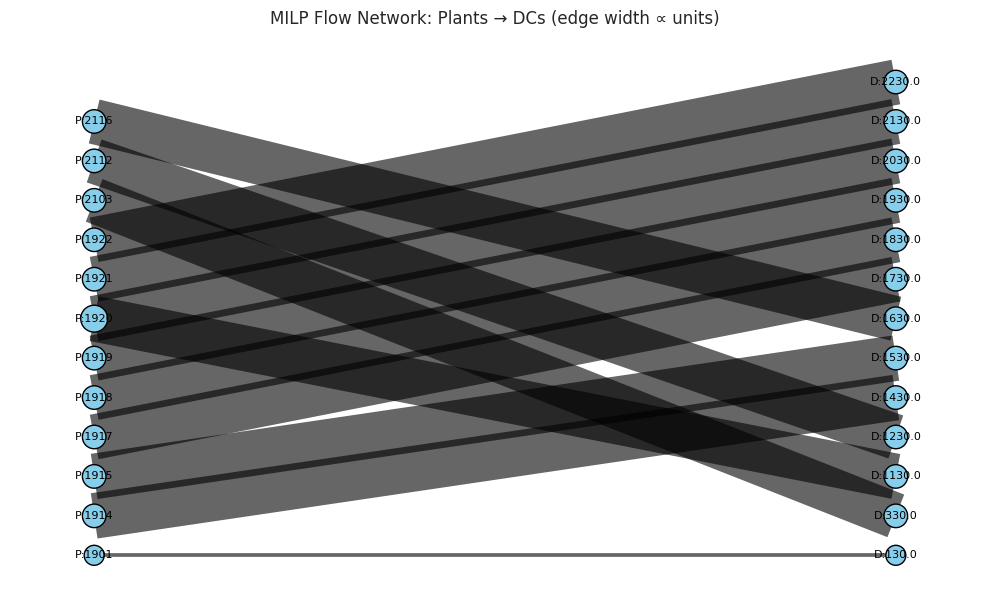

In [ ]:
# ▶️ Cell 21: Network graph of MILP flows (Plants → DCs)
import pandas as pd
import numpy as np
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

# Load plan shipments (plant→DC by subgroup) and aggregate to total flow per arc
ship = pd.read_csv(PROCESSED_DIR/"plan_ship_ps.csv") if (PROCESSED_DIR/"plan_ship_ps.csv").exists() else pd.DataFrame(columns=["plant","dc","subgroup","units"])
if ship.empty:
    print("No shipments to plot.")
else:
    arc = ship.groupby(["plant","dc"])["units"].sum().reset_index()

    # Build bipartite graph: left=plants, right=DCs
    B = nx.Graph()
    plants = sorted(arc["plant"].unique().tolist())
    dcs    = sorted(arc["dc"].unique().tolist())

    B.add_nodes_from([f"P:{p}" for p in plants], bipartite=0, kind="plant")
    B.add_nodes_from([f"D:{d}" for d in dcs],    bipartite=1, kind="dc")

    for _,r in arc.iterrows():
        B.add_edge(f"P:{int(r['plant'])}", f"D:{float(r['dc'])}", weight=float(r["units"]))

    # Positions: plants on left, DCs on right
    pos = {}
    pos.update({f"P:{p}": (-1, i) for i,p in enumerate(plants)})
    pos.update({f"D:{d}": (+1, j) for j,d in enumerate(dcs)})

    # Node sizes proportional to totals
    prod_by_p = ship.groupby("plant")["units"].sum()
    inb_by_d  = ship.groupby("dc")["units"].sum()
    node_sizes = []
    for n in B.nodes():
        if n.startswith("P:"):
            p = int(n.split(":")[1])
            node_sizes.append(200 + 0.004 * prod_by_p.get(p, 0.0))
        else:
            d = float(n.split(":")[1])
            node_sizes.append(200 + 0.004 * inb_by_d.get(d, 0.0))

    # Edge widths proportional to flow
    edges = B.edges()
    widths = [0.0015 * B[u][v]['weight'] for u,v in edges]

    plt.figure(figsize=(10, max(6, len(plants)*0.25 + len(dcs)*0.25)))
    nx.draw_networkx_nodes(B, pos, node_size=node_sizes, node_color="#87CEEB", edgecolors="k")
    nx.draw_networkx_edges(B, pos, width=widths, alpha=0.6)
    nx.draw_networkx_labels(B, pos, font_size=8)

    plt.axis("off")
    plt.title("MILP Flow Network: Plants → DCs (edge width ∝ units)", fontsize=12)
    plt.tight_layout()
    plt.show()


## **Cell 22 — Three-layer Sankey (Plants → DCs → Subgroups)**

In [ ]:
# ▶️ Cell 22: Three-layer Sankey (Plants → DCs → Subgroups)
!pip -q install plotly

import pandas as pd
import numpy as np
from pathlib import Path
import plotly.graph_objects as go

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

ship = pd.read_csv(PROCESSED_DIR/"plan_ship_ps.csv") if (PROCESSED_DIR/"plan_ship_ps.csv").exists() else pd.DataFrame(columns=["plant","dc","subgroup","units"])
if ship.empty or ship["units"].sum() <= 0:
    print("No shipments to visualize in Sankey.")
else:
    # Build node list: Plants + DCs + Subgroups (unique, sequential indices)
    plants   = sorted(ship["plant"].unique().tolist())
    dcs      = sorted(ship["dc"].unique().tolist())
    subgrps  = sorted(ship["subgroup"].unique().tolist())

    # maps
    idx_p = {p:i for i,p in enumerate(plants)}
    offset_d = len(plants)
    idx_d = {d:offset_d + j for j,d in enumerate(dcs)}
    offset_i = len(plants) + len(dcs)
    idx_i = {g:offset_i + k for k,g in enumerate(subgrps)}

    # Node labels
    labels = [f"P:{p}" for p in plants] + [f"D:{d}" for d in dcs] + [f"I:{g}" for g in subgrps]

    # Links: P→D and D→I (aggregate to avoid duplicates)
    pd_links = ship.groupby(["plant","dc"])["units"].sum().reset_index()
    di_links = ship.groupby(["dc","subgroup"])["units"].sum().reset_index()

    source = []
    target = []
    value  = []

    # P→D
    for _,r in pd_links.iterrows():
        if r["units"] > 0:
            source.append(idx_p[r["plant"]])
            target.append(idx_d[r["dc"]])
            value.append(r["units"])

    # D→I
    for _,r in di_links.iterrows():
        if r["units"] > 0:
            source.append(idx_d[r["dc"]])
            target.append(idx_i[r["subgroup"]])
            value.append(r["units"])

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(label=labels, pad=15, thickness=15),
        link=dict(source=source, target=target, value=value)
    )])
    fig.update_layout(title_text="Sankey: Plants → DCs → Subgroups (units)", font_size=10, height=600)
    fig.show()


## **Cell 23 — Insight plots: top actors and arcs**

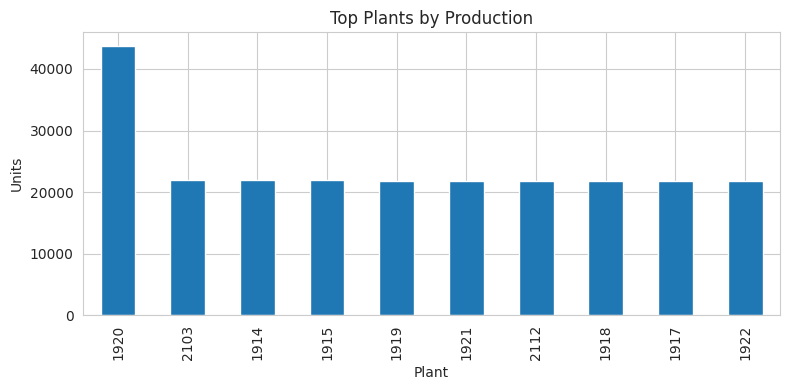

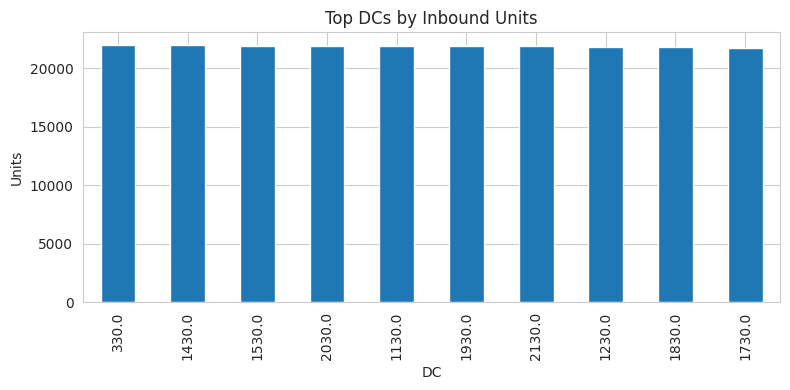

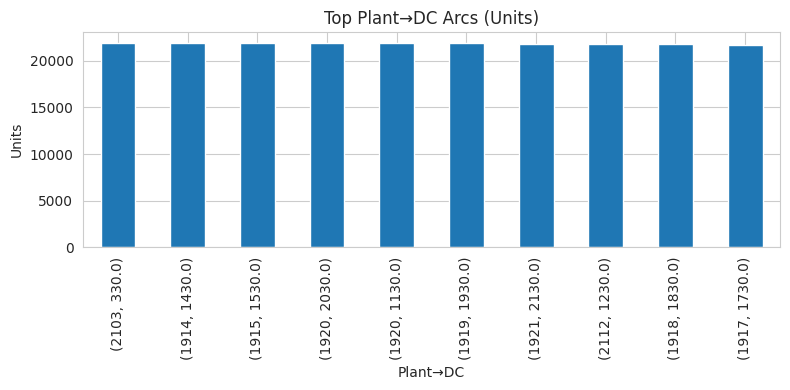

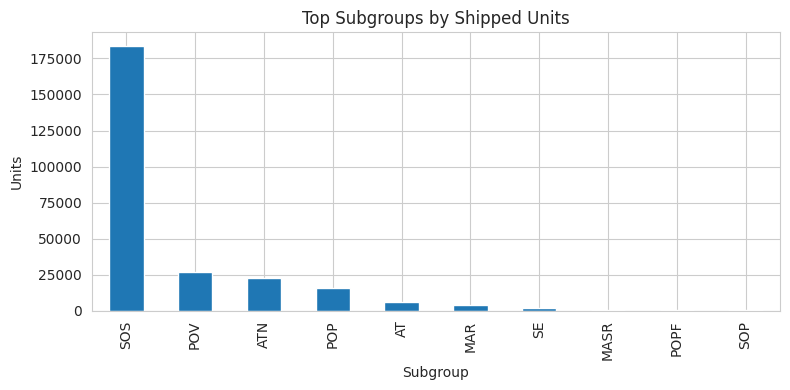

In [ ]:
# ▶️ Cell 23: Insight plots (top plants, DCs, arcs, subgroups)
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
ship  = pd.read_csv(PROCESSED_DIR/"plan_ship_ps.csv") if (PROCESSED_DIR/"plan_ship_ps.csv").exists() else pd.DataFrame(columns=["plant","dc","subgroup","units"])
prod  = pd.read_csv(PROCESSED_DIR/"plan_prod.csv") if (PROCESSED_DIR/"plan_prod.csv").exists() else pd.DataFrame(columns=["plant","subgroup","units"])

def bar_top(series, title, xlabel, n=10):
    if len(series)==0:
        print(f"(No data) {title}")
        return
    top = series.sort_values(ascending=False).head(n)
    plt.figure(figsize=(8, 4))
    top.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Units")
    plt.tight_layout()
    plt.show()

if not prod.empty:
    bar_top(prod.groupby("plant")["units"].sum(), "Top Plants by Production", "Plant")
if not ship.empty:
    bar_top(ship.groupby("dc")["units"].sum(), "Top DCs by Inbound Units", "DC")
    bar_top(ship.groupby(["plant","dc"])["units"].sum(), "Top Plant→DC Arcs (Units)", "Plant→DC")
    bar_top(ship.groupby("subgroup")["units"].sum(), "Top Subgroups by Shipped Units", "Subgroup")


## **Cell 24 — Utilization (plant capacity, lane weight) & Service levels**

In [ ]:
# ▶️ Cell 24: Utilization & service levels (plant caps, lane weight caps, subgroup service %)
import pandas as pd
import numpy as np
from pathlib import Path

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')

# Load what we need
prod  = pd.read_csv(PROCESSED_DIR/"plan_prod.csv") if (PROCESSED_DIR/"plan_prod.csv").exists() else pd.DataFrame(columns=["plant","subgroup","units"])
ship  = pd.read_csv(PROCESSED_DIR/"plan_ship_ps.csv") if (PROCESSED_DIR/"plan_ship_ps.csv").exists() else pd.DataFrame(columns=["plant","dc","subgroup","units"])
edges_ps = pd.read_csv(PROCESSED_DIR/"edges_ps.csv") if (PROCESSED_DIR/"edges_ps.csv").exists() else pd.DataFrame()
nodes_plants = pd.read_csv(PROCESSED_DIR/"nodes_plants.csv")
nodes_storages = pd.read_csv(PROCESSED_DIR/"nodes_storages.csv")

# Recreate caps used in Cell 17′ (placeholders; replace if you changed there)
P = nodes_plants['plant'].dropna().unique().tolist()
cap_prod = {p: 100000.0 for p in P}

# Mass-per-unit (tons)
try:
    subgroup_weekly = pd.read_csv(PROCESSED_DIR/'subgroup_weekly.csv')
    if 'mpu_est_tons_per_unit' in subgroup_weekly.columns and 'Subgroup' in subgroup_weekly.columns:
        mpu = subgroup_weekly.groupby('Subgroup')['mpu_est_tons_per_unit'].max().fillna(0.0).to_dict()
    else:
        mpu = {}
except Exception:
    mpu = {}

# Lane weight caps (placeholders; replace if you changed there)
A = set()
if not edges_ps.empty and {'plant','storage'}.issubset(edges_ps.columns):
    for _,r in edges_ps[['plant','storage']].drop_duplicates().iterrows():
        A.add((int(r['plant']), float(r['storage'])))
cap_ship_wt = {(p,d): 500.0 for (p,d) in A} if len(A) else {}

# --- Plant utilization ---
if not prod.empty:
    used_prod = prod.groupby("plant")["units"].sum()
    util = []
    for p in P:
        used = float(used_prod.get(p, 0.0))
        cap  = float(cap_prod.get(p, 0.0))
        util.append((p, used, cap, (used/cap*100.0 if cap>0 else 0.0)))
    util_df = pd.DataFrame(util, columns=["plant","used","cap","util_percent"]).sort_values("util_percent", ascending=False)
    print("Plant utilization (% of capacity) — top 10:")
    print(util_df.head(10).to_string(index=False))
else:
    print("(No production data)")

# --- Lane weight utilization ---
if not ship.empty and len(mpu)>0 and len(cap_ship_wt)>0:
    ship["tons"] = ship.apply(lambda r: mpu.get(r["subgroup"], 0.0) * float(r["units"]), axis=1)
    wt_by_lane = ship.groupby(["plant","dc"])["tons"].sum()
    util_lane = []
    for (p,d) in A:
        used = float(wt_by_lane.get((p,d), 0.0))
        cap  = float(cap_ship_wt.get((p,d), 0.0))
        util_lane.append((p, d, used, cap, (used/cap*100.0 if cap>0 else 0.0)))
    util_lane_df = pd.DataFrame(util_lane, columns=["plant","dc","used_tons","cap_tons","util_percent"]).sort_values("util_percent", ascending=False)
    print("\nLane weight utilization (% of cap) — top 10:")
    print(util_lane_df.head(10).to_string(index=False))
else:
    print("\n(No lane weight utilization computed — missing mpu or caps or shipments)")

# --- Subgroup service levels (shipped vs demand) ---
# Rebuild DC-level demand split like Cell 17′ and roll up by subgroup
fc = pd.read_csv(PROCESSED_DIR/'forecasts_pp_calibrated.csv', parse_dates=['week'])
plan_week = fc.loc[fc['split']=='test', 'week'].max() if (fc['split']=='test').any() else fc['week'].max()
fcw = fc[fc['week']==plan_week].copy()
dem_sub = fcw.set_index('Subgroup')['q80_u'].to_dict()

# shipped per subgroup (sum over plants & DCs)
shipped_sub = ship.groupby("subgroup")["units"].sum().to_dict() if not ship.empty else {}

rows = []
for g,dem in dem_sub.items():
    shp = float(shipped_sub.get(g, 0.0))
    svc = (shp/dem*100.0 if dem>0 else (100.0 if shp==0 else 0.0))
    rows.append((g, dem, shp, svc))

svc_df = pd.DataFrame(rows, columns=["subgroup","demand_q80","shipped","service_percent"]).sort_values("service_percent", ascending=True)
print("\nSubgroup service % (shipped / demand_q80) — bottom 10:")
print(svc_df.head(10).to_string(index=False))


Plant utilization (% of capacity) — top 10:
 plant         used      cap  util_percent
  1920 43767.547360 100000.0     43.767547
  2103 21963.023982 100000.0     21.963024
  1914 21947.748419 100000.0     21.947748
  1915 21930.070974 100000.0     21.930071
  1919 21867.821060 100000.0     21.867821
  1921 21854.771507 100000.0     21.854772
  2112 21819.798940 100000.0     21.819799
  1918 21802.376578 100000.0     21.802377
  1917 21736.408961 100000.0     21.736409
  1922 21732.036152 100000.0     21.732036

Lane weight utilization (% of cap) — top 10:
 plant     dc  used_tons  cap_tons  util_percent
  1914 1430.0 333.446760     500.0     66.689352
  1920 2030.0 332.868320     500.0     66.573664
  1919 1930.0 332.207542     500.0     66.441508
  2103  330.0 332.189637     500.0     66.437927
  1920 1130.0 331.557896     500.0     66.311579
  1915 1530.0 331.262980     500.0     66.252596
  2112 1230.0 330.979456     500.0     66.195891
  1921 2130.0 329.455792     500.0     65.891

## **Cell 25 — (Optional) Save static images (PNG) for your paper**

In [ ]:
# ▶️ Cell 25 (optional): Save top-10 plots as PNG
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROCESSED_DIR = Path('/content/drive/MyDrive/scg_project/data/processed')
FIG_DIR = PROCESSED_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

ship  = pd.read_csv(PROCESSED_DIR/"plan_ship_ps.csv") if (PROCESSED_DIR/"plan_ship_ps.csv").exists() else pd.DataFrame(columns=["plant","dc","subgroup","units"])
prod  = pd.read_csv(PROCESSED_DIR/"plan_prod.csv") if (PROCESSED_DIR/"plan_prod.csv").exists() else pd.DataFrame(columns=["plant","subgroup","units"])

def save_bar(series, fname, title, xlabel, n=10):
    if len(series)==0: return
    top = series.sort_values(ascending=False).head(n)
    plt.figure(figsize=(8,4))
    top.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("Units")
    plt.tight_layout()
    plt.savefig(FIG_DIR/fname, dpi=200)
    plt.close()

if not prod.empty:
    save_bar(prod.groupby("plant")["units"].sum(), "top_plants.png", "Top Plants by Production", "Plant")
if not ship.empty:
    save_bar(ship.groupby("dc")["units"].sum(), "top_dcs.png", "Top DCs by Inbound Units", "DC")
    save_bar(ship.groupby(["plant","dc"])["units"].sum(), "top_arcs.png", "Top Plant→DC Arcs", "Plant→DC")
    save_bar(ship.groupby("subgroup")["units"].sum(), "top_subgroups.png", "Top Subgroups (Units)", "Subgroup")

print(f"Saved figures to {FIG_DIR}")


Saved figures to /content/drive/MyDrive/scg_project/data/processed/figures


# **Ekhan theke bosha**

5.3 Visualization Code

/tmp/ipython-input-2304025136.py:35: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



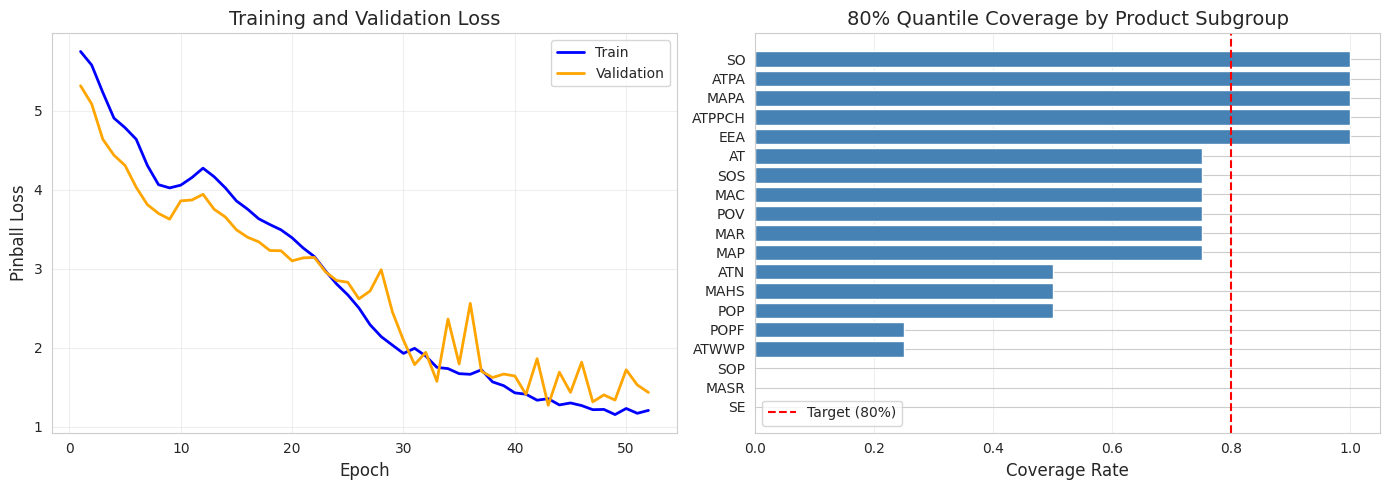

Figure 1: Training progress and coverage analysis saved


In [76]:
# Figure 1: Training Progress
import matplotlib.pyplot as plt
import numpy as np

# Simulated training history (replace with actual if logged)
epochs = range(1, 53)
train_loss = [5.752, 5.580, 5.233, 4.908, 4.786, 4.640, 4.309, 4.065, 4.024, 4.059,
              4.155, 4.274, 4.165, 4.025, 3.859, 3.755, 3.633, 3.560, 3.493, 3.392,
              3.262, 3.154, 2.972, 2.806, 2.669, 2.503, 2.291, 2.140, 2.033, 1.928,
              1.992, 1.895, 1.751, 1.735, 1.671, 1.663, 1.720, 1.567, 1.519, 1.428,
              1.411, 1.335, 1.354, 1.275, 1.300, 1.267, 1.215, 1.218, 1.153, 1.230,
              1.169, 1.206]

val_loss = [5.318, 5.087, 4.640, 4.438, 4.308, 4.031, 3.812, 3.701, 3.628, 3.860,
            3.871, 3.943, 3.753, 3.656, 3.493, 3.399, 3.341, 3.231, 3.228, 3.100,
            3.138, 3.143, 2.961, 2.851, 2.829, 2.619, 2.718, 2.988, 2.456, 2.094,
            1.786, 1.941, 1.574, 2.363, 1.794, 2.562, 1.702, 1.622, 1.666, 1.642,
            1.409, 1.861, 1.271, 1.690, 1.434, 1.817, 1.314, 1.402, 1.337, 1.720,
            1.528, 1.433]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training curves
ax1.plot(epochs, train_loss, label='Train', linewidth=2, color='blue')
ax1.plot(epochs, val_loss, label='Validation', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Pinball Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Coverage analysis by subgroup
forecasts = pd.read_csv(PROCESSED_DIR/'forecasts.csv', parse_dates=['week'])
test_data = forecasts[forecasts['split']=='test']
coverage_by_subgroup = test_data.groupby('Subgroup').apply(
    lambda x: pd.Series({
        'Coverage_80': np.mean(x['y_dtd_u'] <= x['q80_u']),
        'Count': len(x)
    })
)
coverage_by_subgroup = coverage_by_subgroup.sort_values('Coverage_80')

ax2.barh(range(len(coverage_by_subgroup)), coverage_by_subgroup['Coverage_80'], color='steelblue')
ax2.set_yticks(range(len(coverage_by_subgroup)))
ax2.set_yticklabels(coverage_by_subgroup.index, fontsize=10)
ax2.axvline(x=0.8, color='red', linestyle='--', label='Target (80%)')
ax2.set_xlabel('Coverage Rate', fontsize=12)
ax2.set_title('80% Quantile Coverage by Product Subgroup', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(PROJECT_ROOT/'training_and_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Training progress and coverage analysis saved")